In [5]:
# Load all helper function
%run -i 'source.py'
train = pd.read_feather("../processing/train_with_feature.feather")

In [3]:
def extract_agg(train, group):
    '''
    Extract the aggregated features
    '''
    df_by_ = train.groupby(group, as_index=False)[['click_freq_by_' + group, 'download_rate_by_' + group]].first().sort_values(by='click_freq_by_' + group, ascending=False).reset_index(drop=True)
    df_by_['download_freq_by_' + group] = df_by_['click_freq_by_' + group] * df_by_['download_rate_by_' + group]
    df_by_['download_freq_by_' + group] = df_by_['download_freq_by_' + group].astype('int')
    df_by_['download_rate_by_' + group] = df_by_['download_rate_by_' + group].astype(float)
    return df_by_

def extract_agg_2(train, group):
    '''
    Extract the aggregated features with multiple grouping
    '''
    df_by_ = train.groupby(group, as_index=False)[['click_freq_by_' + '_'.join(group), 'download_rate_by_' + '_'.join(group)]].first().sort_values(by='click_freq_by_' + '_'.join(group), ascending=False).reset_index(drop=True)
    df_by_['download_freq_by_' + '_'.join(group)] = df_by_['click_freq_by_' + '_'.join(group)] * df_by_['download_rate_by_' + '_'.join(group)]
    df_by_['download_freq_by_' + '_'.join(group)] = df_by_['download_freq_by_' + '_'.join(group)].astype('int')
    df_by_['download_rate_by_' + '_'.join(group)] = df_by_['download_rate_by_' + '_'.join(group)].astype('float')
    return df_by_

# EDV on single variables

> This notebook contains our comprehensive trial on investing on the raw data and features we created. Plots that selected to present in the slides are those followed buy outputing to the `../output/` directory.

## Overall

### label

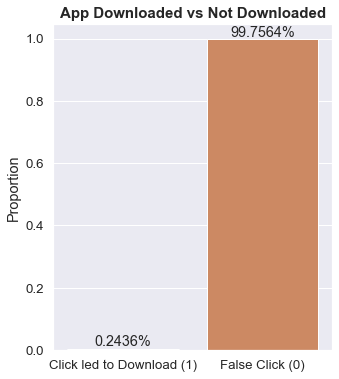

In [38]:
plt.figure(figsize=(5, 6))
sns.set(font_scale=1.2)
ProportionConverted = (train.is_attributed.values == 1).mean()
ax = sns.barplot(x=['Click led to Download (1)', 'False Click (0)'],
                 y=[ProportionConverted, 1-ProportionConverted])
ax.set(ylabel='Proportion')
ax.set_title('App Downloaded vs Not Downloaded', weight = 'bold', size = 15)
# ax.bar_label(ax.containers[0])
for p, uniq in zip(ax.patches, [ProportionConverted, 1-ProportionConverted]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 4)),
            ha="center")
plt.savefig('../output/target imbalances.png', dpi=300, bbox_inches='tight')
plt.show()

- Only a small proportion of clicks were followed by a download.

### features

/Users/jace/opt/anaconda3/envs/PYFORAML/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


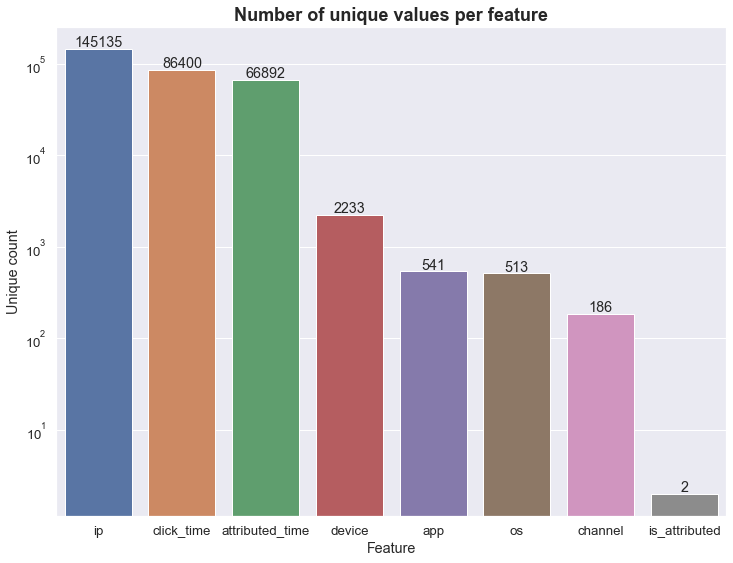

In [23]:
plt.figure(figsize=(12, 9))
cols = ['ip','app','device','os','channel','click_time','attributed_time','is_attributed']
uniques = train[cols].nunique().sort_values(ascending=False)
sns.set(font_scale=1.2)
ax = sns.barplot(uniques.index, uniques.values, log=True)
ax.set(xlabel='Feature', ylabel='Unique count')
ax.set_title('Number of unique values per feature', weight = 'bold', size = 18)
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height*1.05,
            uniq,
            ha="center")
plt.savefig('../output/feature counts.png', dpi=300, bbox_inches='tight')

- The ip address has the most unique number, and the others are below 10000.

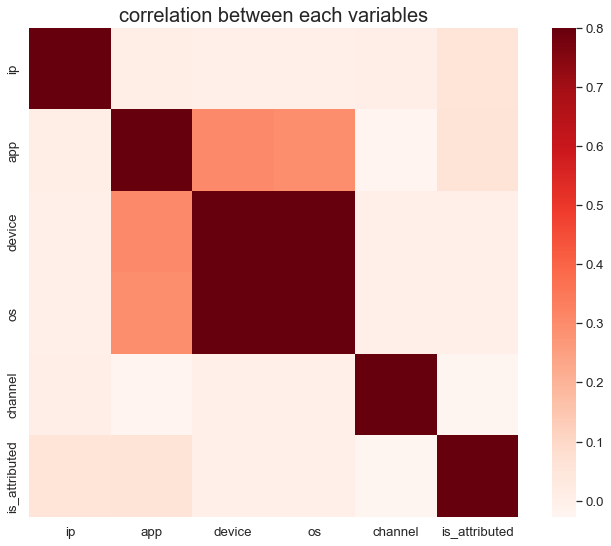

In [23]:
corrmat = train[cols].corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap='Reds',vmax=.8, square=True, ax=ax);
ax.set_title("correlation between each variables", fontsize= 20);

There seems to be a strong correlation between OS, device, and application, but we can not find anything strongly correlated with the 'is_attrained' variable.
If I had to choose IP　and application.

Now I read [Actual condition of chilk frauder](https://www.gizmodo.jp/2017/06/thai-click-fraud-farm-busted-using-wall-of-iphones.html),
I made the following four guesses

1. Did they click on a large number with the same ip address?
1. Did they click on the same device, OS?
1. If Developers of competing applications conduct click fraud, is the number of clicks increased with a specific application?
1. If Ad network companies applications conduct click fraud, is the number of clicks increased with a specific channel?

In [64]:
df_by_ip[df_by_ip["download_rate_by_ip"] == 0]

ip  click_freq_by_ip  download_rate_by_ip  download_freq_by_ip  \
464     116472              8771              0.00000                    0   
519     173141              8277              0.00000                    0   
580      60271              7779              0.00000                    0   
639      14672              7444              0.00000                    0   
735     276088              7044              0.00000                    0   
...        ...               ...                  ...                  ...   
145105  223685                 1              0.00000                    0   
145107  282661                 1              0.00000                    0   
145120  282718                 1              0.00000                    0   
145122  282715                 1              0.00000                    0   
145132  282681                 1              0.00000                    0   

               clicker_type downloader_type  
464             big_clicker              No  
519             big_clicker              No  
580             big_clicker              No  
639             big_clicker              No  
735             big_clicker              No  
...                     ...             ...  
145105  very_little_clicker              No  
145107  very_little_clicker              No  
145120  very_little_clicker              No  
145122  very_little_clicker              No  
145132  very_little_clicker              No  

[49461 rows x 6 columns]

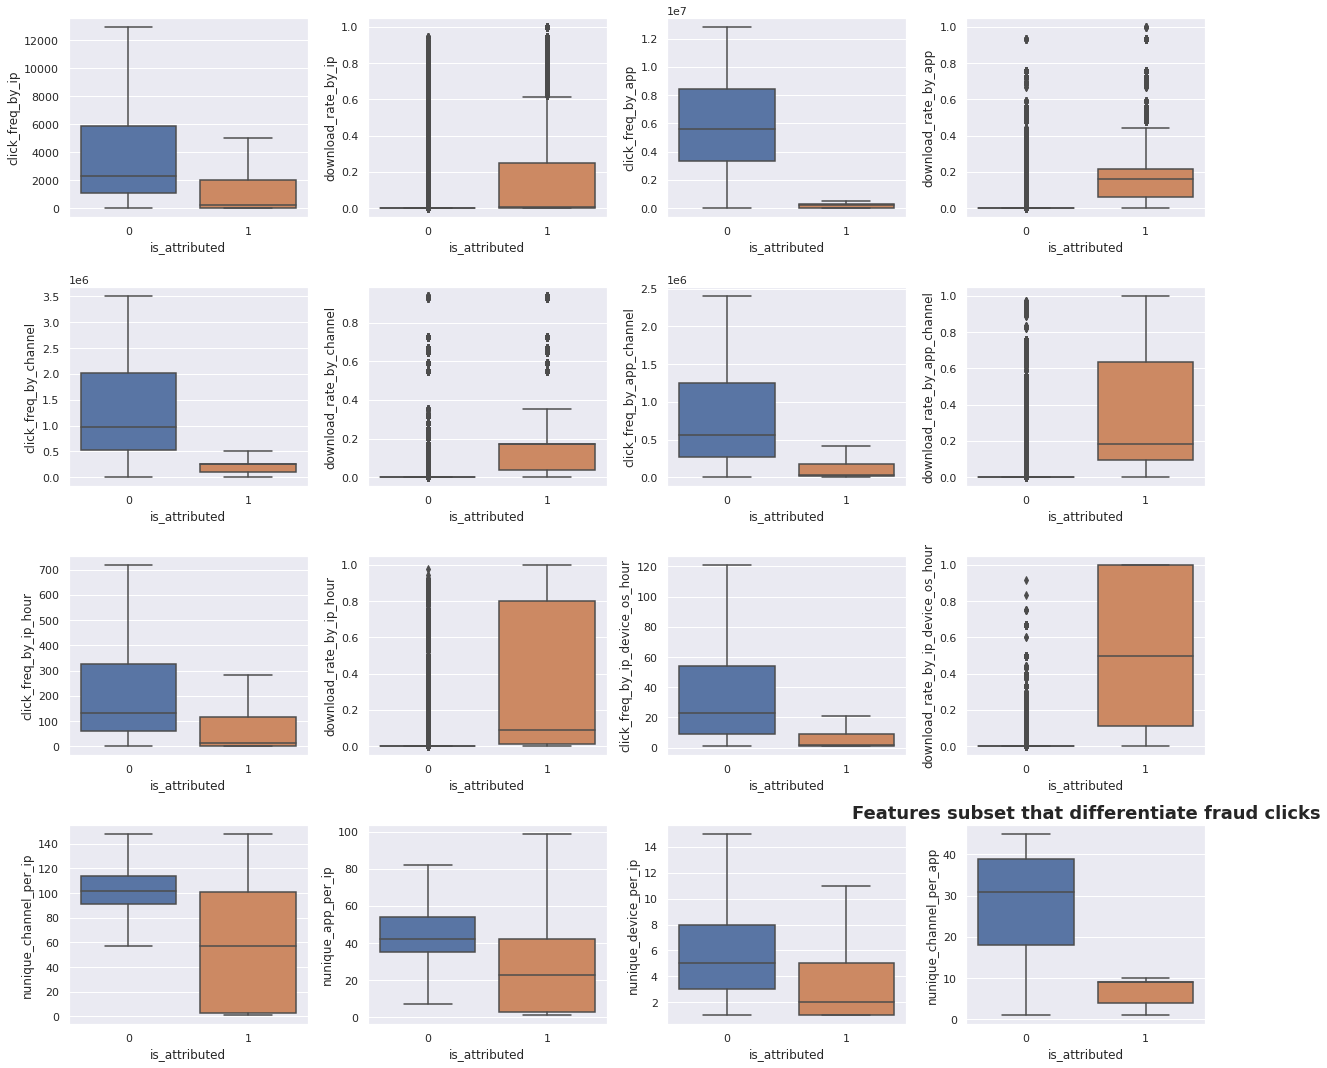

In [6]:
cols = ['click_freq_by_ip', 'download_rate_by_ip', 'click_freq_by_app',
       'download_rate_by_app', 'click_freq_by_channel', 'download_rate_by_channel',
       'click_freq_by_app_channel', 'download_rate_by_app_channel',
       'click_freq_by_ip_hour', 'download_rate_by_ip_hour',
       'click_freq_by_ip_device_os_hour', 'download_rate_by_ip_device_os_hour',
       'nunique_channel_per_ip', 'nunique_app_per_ip',
       'nunique_device_per_ip', 'nunique_channel_per_app']


fig, ax = plt.subplots(4,4, figsize=(17, 15)) 
i = 0
for feature in cols:
    i+= 1
    plt.subplot(4,4,i)
    if "download_rate" in feature:
        sns.boxplot(x='is_attributed', y=feature, data=train,showfliers=True)
    else:
        sns.boxplot(x='is_attributed', y=feature, data=train,showfliers=False)
plt.title("Features subset that differentiate fraud clicks", weight = 'bold', size = 18)
plt.tight_layout()
plt.savefig('../output/feature multiple plots.png', dpi=300, bbox_inches='tight')

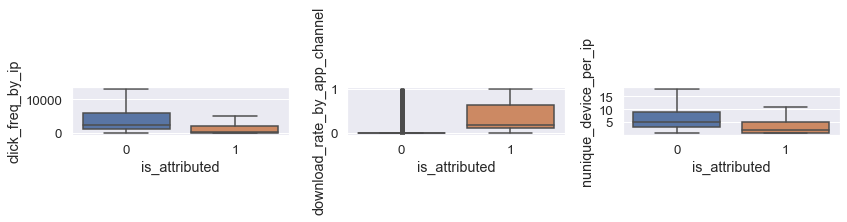

In [72]:
cols = ['click_freq_by_ip', 'download_rate_by_app_channel', 'nunique_device_per_ip']


fig, ax = plt.subplots(1,3, figsize=(12, 4)) 
i = 0
for feature in cols:
    i+= 1
    plt.subplot(3,3,i)
    if "download_rate" in feature:
        sns.boxplot(x='is_attributed',y=feature,data=train,showfliers=True)
    else:
        sns.boxplot(x='is_attributed',y=feature,data=train,showfliers=False)
# plt.title("Features subset that differentiate fraud clicks", weight = 'bold', size = 18)
plt.tight_layout()
plt.savefig('../output/feature multiple plots.png', dpi=300, bbox_inches='tight')

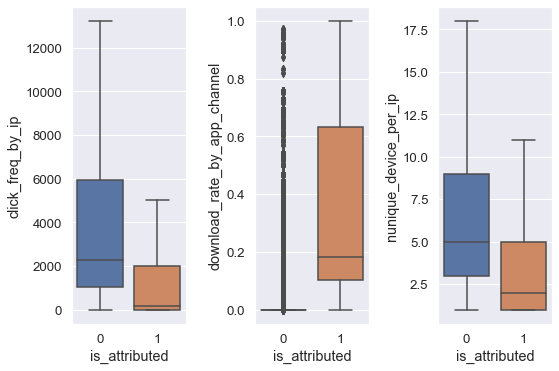

In [87]:
cols = ['click_freq_by_ip', 'download_rate_by_app_channel', 'nunique_device_per_ip']


fig, ax = plt.subplots(1,3, figsize=(8, 7.6*2)) 
i = 0
for feature in cols:
    i+= 1
    plt.subplot(3,3,i)
    if "download_rate" in feature:
        sns.boxplot(x='is_attributed',y=feature,data=train,showfliers=True)
    else:
        sns.boxplot(x='is_attributed',y=feature,data=train,showfliers=False)
# plt.title("Features subset that differentiate fraud clicks", weight = 'bold', size = 18)
plt.tight_layout()
plt.savefig('../output/feature multiple plots.png', dpi=300, bbox_inches='tight')

## IPs

In [39]:
df_by_ip = extract_agg(train, 'ip')

### Check if IP can be used to predict conversion rate.

We want to see if we can identify some bots from the data. A bot would likely have many clicks from the same ip but would have a very low/zero conversion rate.

We see there are about 200,000 IPs that are repeated and lead to downloads, so we can't dismiss a repeated IP as a bot without any further observation.

A better way of seeing this is to examine the conversion rate of the most popular IP addresses.

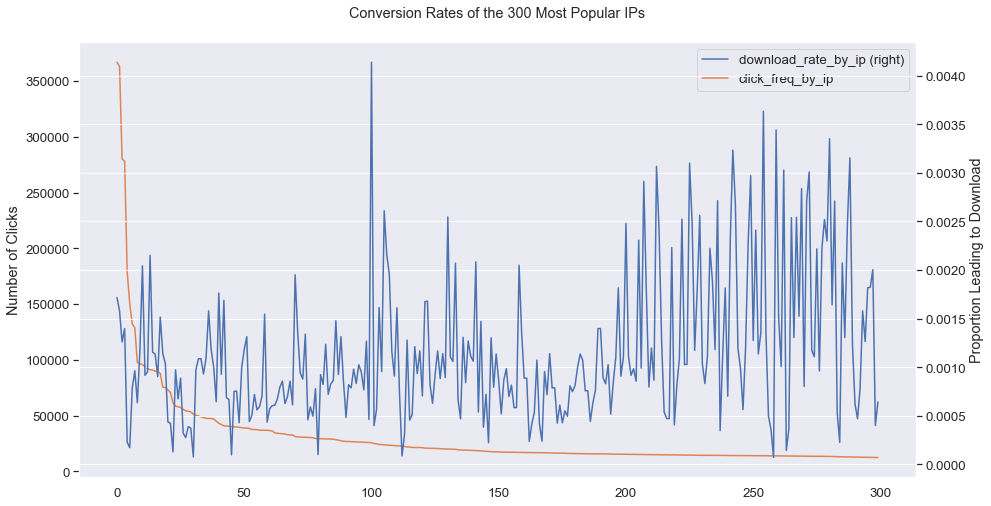

In [40]:
ax = df_by_ip.nlargest(300, 'click_freq_by_ip')[['download_rate_by_ip', 'click_freq_by_ip']].reset_index(drop=True).plot(secondary_y='download_rate_by_ip')
plt.title('Conversion Rates of the 300 Most Popular IPs', pad=25)
ax.set(ylabel='Number of Clicks')
plt.ylabel('Proportion Leading to Download');
plt.gcf().set_size_inches(15, 8)

Not super helpful; we see there are some cases where we have a massive number of clicks. These have a conversion rate of .2% There are also cases where we have very few clicks but also have a conversion rate of .2%. This data is too noisy to ascertain any clear patterns from.

### Extreme IPS

In [41]:
df_by_ip.nlargest(20, 'click_freq_by_ip')

ip  click_freq_by_ip  download_rate_by_ip  download_freq_by_ip
0     5348            366848              0.00172                  630
1     5314            363079              0.00158                  574
2    73516            279944              0.00126                  352
3    73487            278115              0.00140                  389
4    53454            179065              0.00023                   41
5   114276            150838              0.00017                   26
6    26995            132216              0.00079                  104
7    95766            128616              0.00096                  124
8    86767             97611              0.00064                   61
9   100275             96541              0.00117                  112
10    5178             95843              0.00204                  195
11   17149             93690              0.00092                   85
12   43793             92255              0.00095                   87
13    5147             91121              0.00215                  196
14  105560             90946              0.00115                  105
15  201182             89804              0.00114                  102
16  105475             89591              0.00090                   80
17  137052             87725              0.00152                  133
18  119531             75409              0.00114                   86
19   49602             75195              0.00104                   78

Oh no! IP address with many clicks has very few downloads! So IP address is effective for judging whether it is an illegal click.

Let's see the click time of ip "5348" and "5314" with the most clicks on trial.

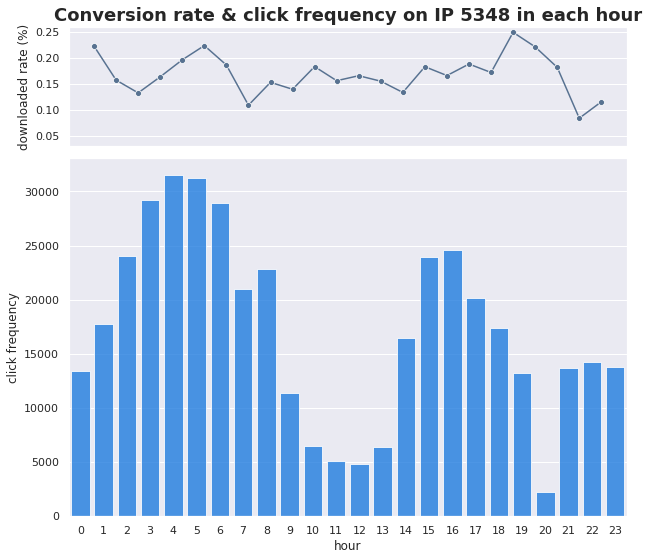

In [4]:
df_by_ip_hour = extract_agg_2(train, ['ip', 'hour']).rename(columns={'download_rate_by_ip_hour':'downloaded rate (%)','click_freq_by_ip_hour':'click frequency'})
df_by_ip_hour['downloaded rate (%)'] = df_by_ip_hour['downloaded rate (%)'] * 100
df_by_ip_hour['hour'] = df_by_ip_hour['hour'].apply(lambda x: (x+8)%24)

fig,ax=plt.subplots(2,1,figsize=(10, 9),gridspec_kw={'height_ratios': [1, 3]})
largest_click_ip = df_by_ip.iloc[0, 0]
largest_click = df_by_ip_hour[df_by_ip_hour['ip'] == largest_click_ip]

sns.lineplot(data=largest_click,x='hour',y='downloaded rate (%)',linewidth = 1.5,color='#587291',marker='o',ax=ax[0])
sns.barplot(x='hour',y='click frequency', data=largest_click,color='#007bff',alpha=0.8,ax=ax[1])
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylim([0.03, 0.26])
plt.subplots_adjust(hspace = .05)
ax[0].set_title('Conversion rate & click frequency on IP ' + str(largest_click_ip) + ' in each hour',  weight = 'bold', fontsize=18)

plt.savefig('../output/ip5348.png', dpi=300, bbox_inches='tight')
plt.show()

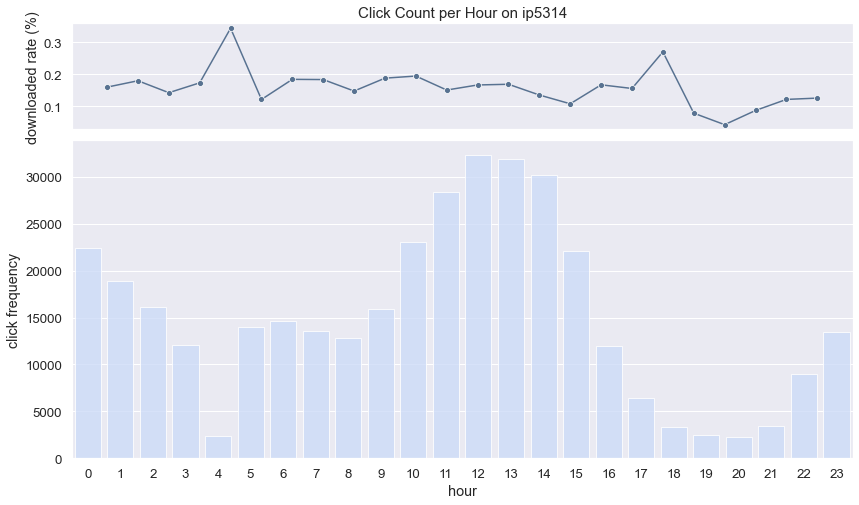

In [43]:
fig,ax=plt.subplots(2,1,figsize=(14, 8),gridspec_kw={'height_ratios': [1, 3]})
second_largest_click_ip = df_by_ip.iloc[1,0]
second_largest_click = df_by_ip_hour[df_by_ip_hour['ip'] == second_largest_click_ip]

sns.lineplot(data=second_largest_click,x='hour',y='downloaded rate (%)',linewidth = 1.5,color='#587291',marker='o',ax=ax[0])
sns.barplot(x='hour',y='click frequency', data=second_largest_click,color='#C6D8FF',alpha=0.8,ax=ax[1])
ax[0].get_xaxis().set_visible(False)
plt.subplots_adjust(hspace = .05)
ax[0].set_title('Click Count per Hour on ip' + str(second_largest_click_ip), fontsize=15)
plt.show()

It is amazing! This ip address's device were clicked all day without sleeping.
This is speculative, but smells of fraudulent clicks.

> Compare this 2 results to the average:

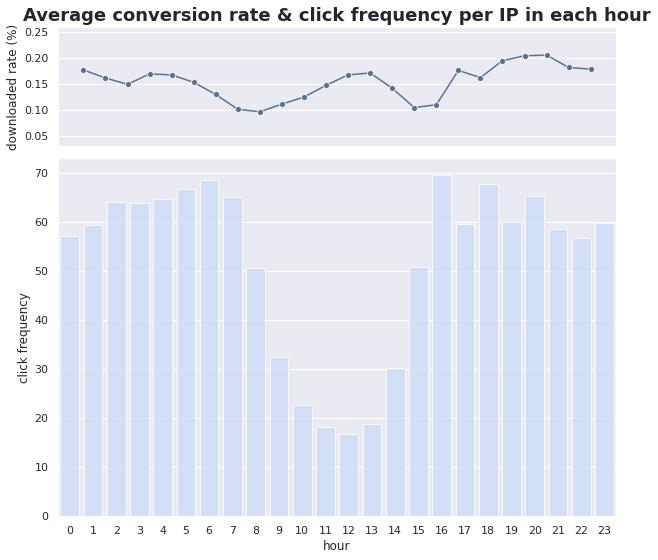

In [5]:
df_by_ip_hour = extract_agg_2(train, ['ip', 'hour']).rename(columns={'click_freq_by_ip_hour':'click frequency'})
df_by_ip_hour['hour'] = df_by_ip_hour['hour'].apply(lambda x: (x+8)%24)
df_overall_hour = df_by_ip_hour.groupby('hour').agg({'click frequency':sum,
                                                     'ip': 'count',
                                                     'download_rate_by_ip_hour': 'mean',
                                                     'download_freq_by_ip_hour':sum}).reset_index()

df_overall_hour['downloaded rate (%)'] = df_overall_hour['download_freq_by_ip_hour']/df_overall_hour['click frequency']*100
#df_overall_hour['downloaded rate (%)'] = df_overall_hour['download_rate_by_ip_hour']
df_overall_hour['click frequency'] = df_overall_hour['click frequency'] / df_overall_hour['ip']

fig,ax=plt.subplots(2,1,figsize=(10, 9),gridspec_kw={'height_ratios': [1, 3]})

sns.lineplot(data=df_overall_hour,x='hour',y='downloaded rate (%)',linewidth = 1.5,color='#587291',marker='o',ax=ax[0])
sns.barplot(x='hour',y='click frequency', data=df_overall_hour,color='#C6D8FF',alpha=0.8,ax=ax[1])
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylim([0.03, 0.26])
plt.subplots_adjust(hspace = .05)
ax[0].set_title('Average conversion rate & click frequency per IP in each hour',  weight = 'bold', fontsize=18)

plt.savefig('../output/average per hour_ip clicks.png', dpi=300, bbox_inches='tight')
plt.show()

> Plot all common "IPs"

<Figure size 864x432 with 0 Axes>

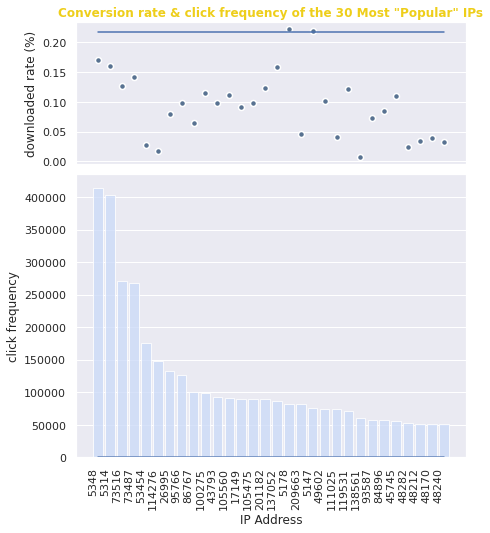

In [6]:
plt.gcf().set_facecolor('#252a31')
df_by_ip = extract_agg(train, 'ip')
top300 = df_by_ip.nlargest(30, 'click_freq_by_ip').rename(columns={'download_rate_by_ip':'downloaded rate (%)',
                                                                    'click_freq_by_ip':'click frequency'})
top300['average download'] = df_by_ip['download_rate_by_ip'].mean()
top300['average click'] = df_by_ip['click_freq_by_ip'].mean()
top300['downloaded rate (%)'] = top300['downloaded rate (%)'] * 100

fig,ax=plt.subplots(2,1,figsize=(7, 8),gridspec_kw={'height_ratios': [1.5, 3]})
sns.scatterplot(data=top300,x=top300.index,y='downloaded rate (%)',linewidth = 1.5,color='#587291',marker='o',ax=ax[0])
sns.barplot(x=top300.index,y='click frequency', data=top300, color='#C6D8FF',alpha=0.8,ax=ax[1])

ax[0].plot(top300.index,top300['average download'])
ax[0].get_xaxis().set_visible(False)
ax[1].set_xticklabels(top300.ip, rotation=90, ha="right")
plt.subplots_adjust(hspace = .05)
ax[0].set_title('Conversion rate & click frequency of the 30 Most "Popular" IPs' , weight = 'bold', fontsize=12, color="#eece1a")
ax[1].get_shared_x_axes().join(ax[1], ax[0])
ax[1].plot(top300.index,top300['average click'])
ax[1].set_xlabel('IP Address')

plt.savefig('../output/30 popular outliers.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()

### distribution

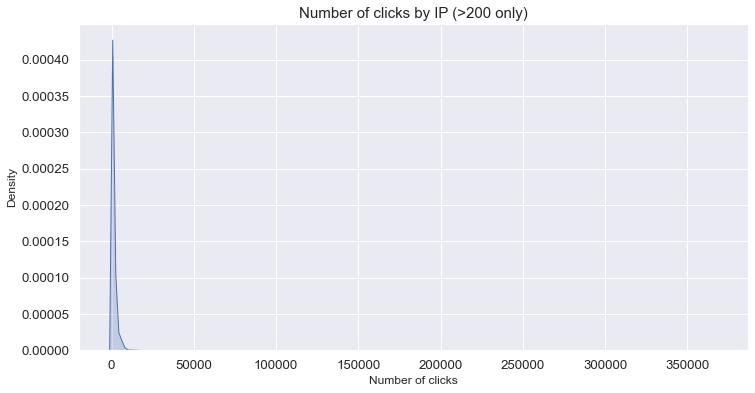

In [44]:
suspicious_IP = df_by_ip[df_by_ip['click_freq_by_ip'] > 200]
sns.kdeplot(suspicious_IP['click_freq_by_ip'], shade=True)
plt.title('Number of clicks by IP (>200 only)', fontsize = 15)
plt.xlabel('Number of clicks', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.show();

- Ok, so even with a threshold of 500 clicks, we can identify some "big clickers" and few "very big clickers". I want to go a little bit deeper and reproduce the same operation with a threshold set at 30000.

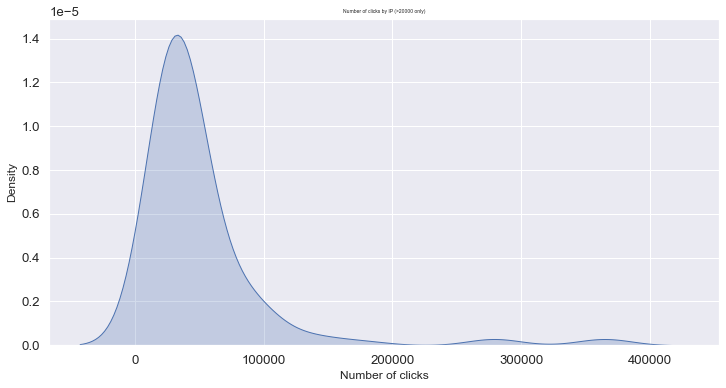

In [45]:
very_suspicious_IP = df_by_ip[df_by_ip['click_freq_by_ip'] > 20000]
sns.kdeplot(very_suspicious_IP['click_freq_by_ip'], shade=True)
plt.title('Number of clicks by IP (>20000 only)', fontsize=5)
plt.xlabel('Number of clicks', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show();

- Great ! We've now a list of 36 789 suspicious IP, and another of 66 very suspicious ! Now it's time to leave the IP level and to go back to the click level to see if those suspicious IP really are.

In [46]:
# Creation of clicker categories
df_by_ip['clicker_type'] = np.select(
    [
        df_by_ip['click_freq_by_ip'].between(0, 10, inclusive='both'),
        df_by_ip['click_freq_by_ip'].between(11, 200, inclusive='both'),
        df_by_ip['click_freq_by_ip'].between(201, 20000, inclusive='both')
    ],
    [
        'very_little_clicker',
        'little_clicker',
        'big_clicker'
    ],
    default='huge_clicker'
)

In [47]:
# Frequencies
print('Minimum number of clicks needed to download an app :', train.click_freq_by_ip[train['is_attributed']==1].min(), '\n')
print("How many IP do we have in each category ?\n", df_by_ip['clicker_type'].value_counts(), '\n')
print("How many clicks, clickers of each caterogy have generate ?\n", df_by_ip.groupby(['clicker_type'])['click_freq_by_ip'].agg('sum'))

Minimum number of clicks needed to download an app : 1 

How many IP do we have in each category ?
 very_little_clicker    60895
little_clicker         44116
big_clicker            39993
huge_clicker             131
Name: clicker_type, dtype: int64 

How many clicks, clickers of each caterogy have generate ?
 clicker_type
big_clicker            53563549
huge_clicker            6696658
little_clicker          2481408
very_little_clicker      203460
Name: click_freq_by_ip, dtype: int32


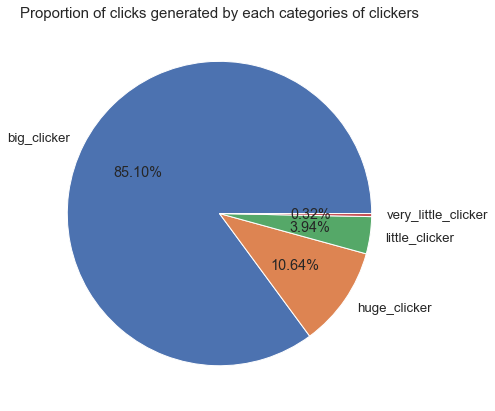

In [48]:
plt.figure(figsize = (7,7))
df_by_ip.groupby(['clicker_type'])['click_freq_by_ip'].agg('sum').plot(kind='pie', autopct='%1.2f%%')
plt.title("Proportion of clicks generated by each categories of clickers", fontsize=15)
plt.ylabel("")
plt.show()

Thereforce, big clickers represents 36 764 IPs (over 145 693) and generate 85% of the clicks and huge clickers represents only 66 IPs but generated 8% of the clicks. Consequently, arround 93% of the clicks are generate by a sub-population of suspicious IPs.
This statistical remember what Talking Data said in the overview "3 billion clicks per day, of which 90% are potentially fraudulent".

Finaly, it looks like watching at the number of clicks by IPs is a great way of identify bots.

### What proportion of IP download the app ?

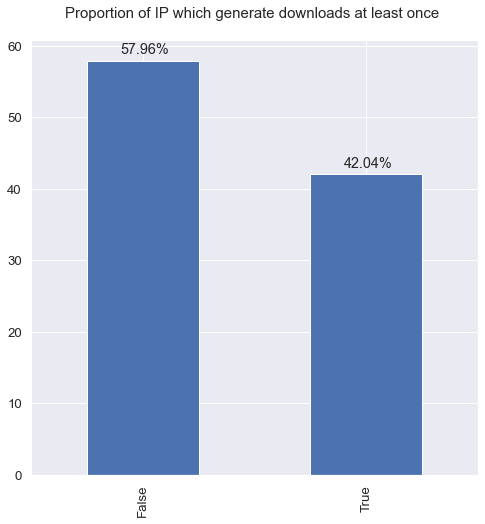

In [49]:
DL_by_IP_agg = (df_by_ip['download_freq_by_ip'] > 0).value_counts(normalize=True)*100

plt.figure(figsize=(8, 8))
plt.title('Proportion of IP which generate downloads at least once \n', fontsize =15)
ax = DL_by_IP_agg.plot(kind='bar')

for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

### **Does bots download the app ?**

In [50]:
df_by_ip['download_freq_by_ip'].describe(percentiles = [.25, .5, .75, .99, .999, .99999, .9999999])

count       145135.00000
mean             0.75407
std              3.45880
min              0.00000
25%              0.00000
50%              0.00000
75%              1.00000
99%              8.00000
99.9%           26.00000
99.999%        490.50210
99.99999%      629.18725
max            630.00000
Name: download_freq_by_ip, dtype: float64

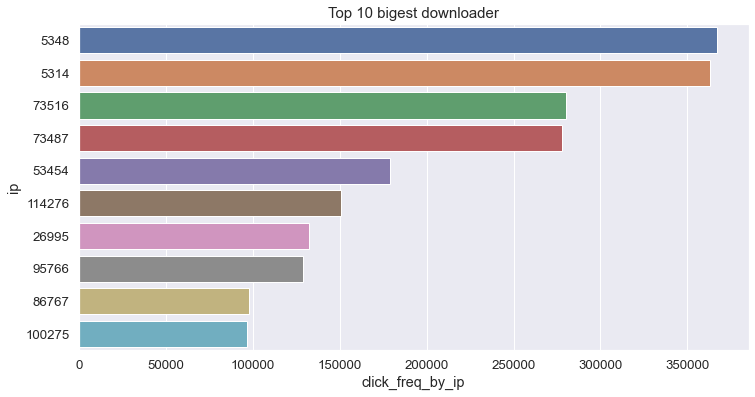

In [66]:
data_to_plot = df_by_ip.nlargest(10, 'click_freq_by_ip')
data_to_plot = data_to_plot.sort_values(by='click_freq_by_ip', ascending=False).reset_index(drop=True)
sns.barplot(x='click_freq_by_ip', y='ip', data=data_to_plot, orient='h', order=data_to_plot['ip'])
plt.title('Top 10 bigest downloader', fontsize=15);

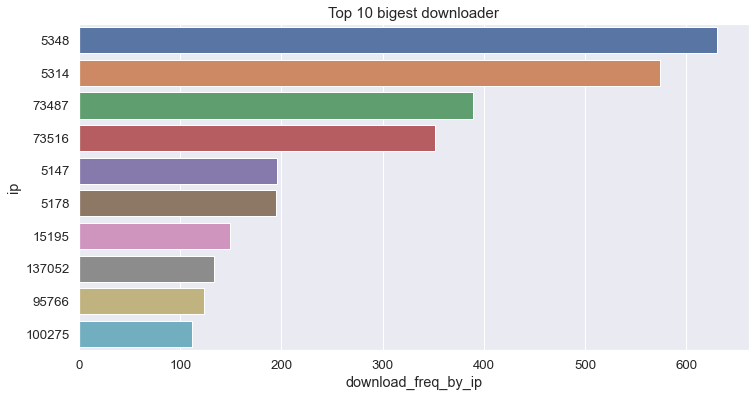

In [51]:
data_to_plot = df_by_ip.nlargest(10, 'download_freq_by_ip')
data_to_plot = data_to_plot.sort_values(by='download_freq_by_ip', ascending=False).reset_index(drop=True)
sns.barplot(x='download_freq_by_ip', y='ip', data=data_to_plot, orient='h', order=data_to_plot['ip'])
plt.title('Top 10 bigest downloader', fontsize=15);

- Our focus is fraud on clicking, there might be fraud on downloading as well but it's not our focus!

### Does standard users download the app ?

In [52]:
# Creation of clicker categories
df_by_ip['downloader_type'] = np.select(
    [
        df_by_ip['download_freq_by_ip'] == 0,
        df_by_ip['download_freq_by_ip'] == 1,
        df_by_ip['download_freq_by_ip'] > 1
    ],
    [
        'No',
        'Yes, once',
        'Yes, multiple times'
    ]
)

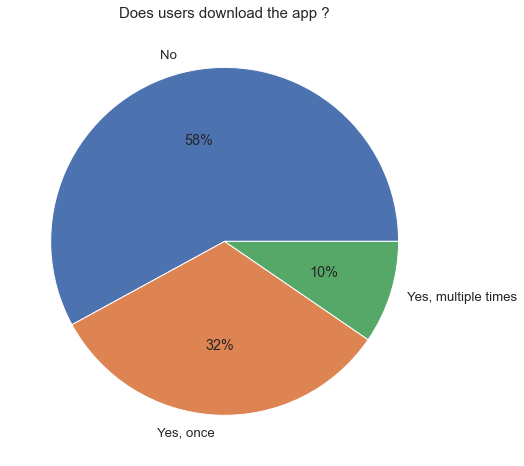

In [53]:
plt.figure(figsize=(8,8))
ax = df_by_ip['downloader_type'].value_counts().plot(kind = 'pie',autopct='%1.0f%%')
ax.set_ylabel("")
ax.set_title('Does users download the app ?', fontsize=15);

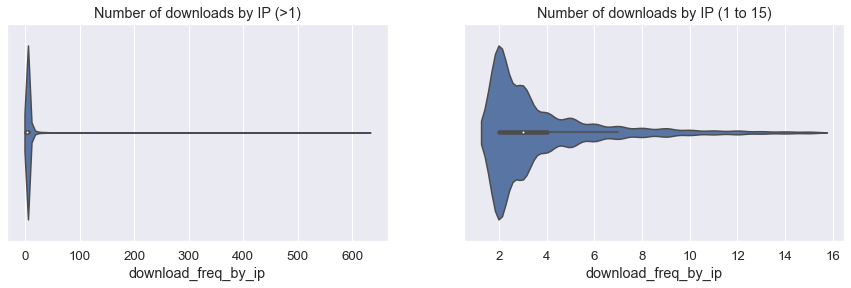

In [54]:
DL_by_IP_morethan1 = df_by_ip[df_by_ip['download_freq_by_ip'] > 1]
DL_by_IP_lessthan15 = DL_by_IP_morethan1[DL_by_IP_morethan1['download_freq_by_ip'] <= 15]

fig, ax = plt.subplots(1,2, figsize =(15,4))
ax[0].title.set_text("Number of downloads by IP (>1)")
sns.violinplot(x = DL_by_IP_morethan1['download_freq_by_ip'], ax = ax[0] )
ax[1].title.set_text("Number of downloads by IP (1 to 15)")
sns.violinplot(x = DL_by_IP_lessthan15['download_freq_by_ip'], ax = ax[1])
plt.show()

In [56]:
df_by_ip

ip  click_freq_by_ip  download_rate_by_ip  download_freq_by_ip  \
0         5348            366848              0.00172                  630   
1         5314            363079              0.00158                  574   
2        73516            279944              0.00126                  352   
3        73487            278115              0.00140                  389   
4        53454            179065              0.00023                   41   
...        ...               ...                  ...                  ...   
145130  282685                 1              1.00000                    1   
145131  282682                 1              1.00000                    1   
145132  282681                 1              0.00000                    0   
145133  282674                 1              1.00000                    1   
145134  240500                 1              1.00000                    1   

               clicker_type      downloader_type  
0              huge_clicker  Yes, multiple times  
1              huge_clicker  Yes, multiple times  
2              huge_clicker  Yes, multiple times  
3              huge_clicker  Yes, multiple times  
4              huge_clicker  Yes, multiple times  
...                     ...                  ...  
145130  very_little_clicker            Yes, once  
145131  very_little_clicker            Yes, once  
145132  very_little_clicker                   No  
145133  very_little_clicker            Yes, once  
145134  very_little_clicker            Yes, once  

[145135 rows x 6 columns]

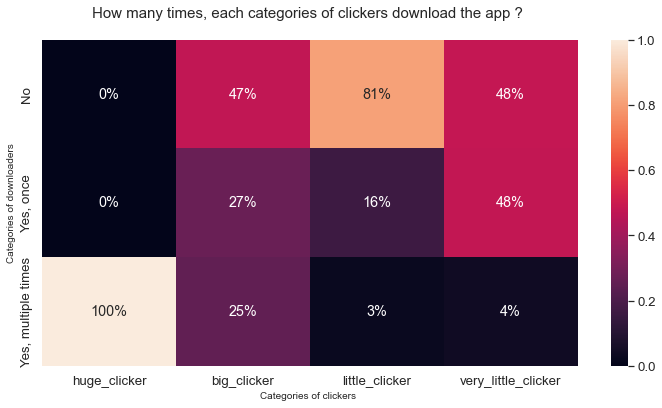

In [60]:
cross_tab = pd.crosstab(df_by_ip['downloader_type'], df_by_ip['clicker_type'], normalize='columns')

# We need to sort the index (because 'Yes, one time' was beofre 'Yes, multiple times')
cross_tab.index = pd.CategoricalIndex(cross_tab.index, categories = ['Yes, multiple times', 'Yes, once', 'No'])
cross_tab = cross_tab.sort_index(ascending = False)

# Same thing for columns
cross_tab = cross_tab[['huge_clicker', 'big_clicker', 'little_clicker', 'very_little_clicker']]

# Ok we can make our graph now
plt.title('How many times, each categories of clickers download the app ? \n', fontsize=15) 
sns.heatmap(cross_tab,annot=True, fmt='.0%')
plt.xlabel('Categories of clickers ', fontsize=10)
plt.ylabel('Categories of downloaders', fontsize=10);

In [61]:
df_by_ip.to_csv("../processing/df_by_ip.csv", index=False)

There is some very interesting information in the graph above : little, and very little clickers (humans) don't download the app, or download it only one time. More they click, more their probability of downloading the app seems high. 

On  another side, big clickers have 38% of chance to download the app multiple times and huge clickers 100%. I guess that my categories are not perfect, the lower bound of 'big clicker' should probably be higher, because, IMO, some standard users (humans) are in this category, and so, have a standard behaviour.

At this point, I think we should keep in mind that the aim of the competition is to predict if the current click will download or not the app, not the user (IP). Identify suspicious IP is great, but we really need to go deeper.

**Download by click ratio :**

I think this indicator could help us to understand what kind of clickers download the app the most, in poportion of there amount of clicks. 

In [42]:
df_by_ip['download_rate_by_ip'] = df_by_ip['download_rate_by_ip'].astype(float)

count   145135.00000
mean         0.18498
std          0.32644
min          0.00000
25%          0.00000
50%          0.00273
75%          0.19995
max          1.00000
Name: download_rate_by_ip, dtype: float64


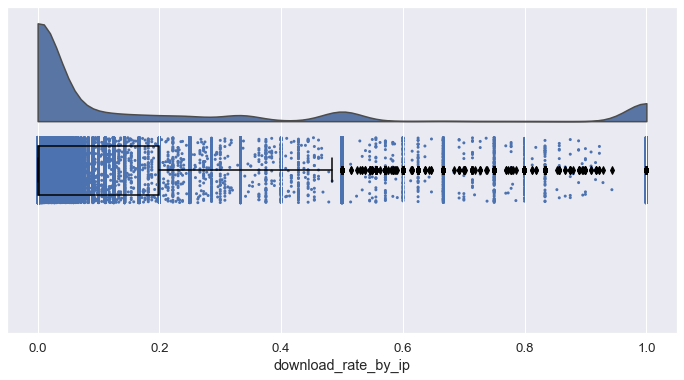

In [43]:
# Ratio global analysis
print(df_by_ip['download_rate_by_ip'].describe())

ax = pt.half_violinplot(x='download_rate_by_ip', data=df_by_ip, bw = .1, cut = 0, scale = "area", width = .6, inner = None)
ax = sns.stripplot(x='download_rate_by_ip', data=df_by_ip, edgecolor = "white",size = 3, jitter = 1, zorder = 0)
ax = sns.boxplot(x='download_rate_by_ip', data=df_by_ip, color="black", width = .15, zorder = 10,\
        showcaps=True, showfliers=True,boxprops = {'facecolor':'none', "zorder":10},saturation=1)

- Unsurprised, most of IPs have a low ratio (50% lower than 0.0025 and 75% lower than 0.2). I guess it would be more interesting to check by category of clicker.


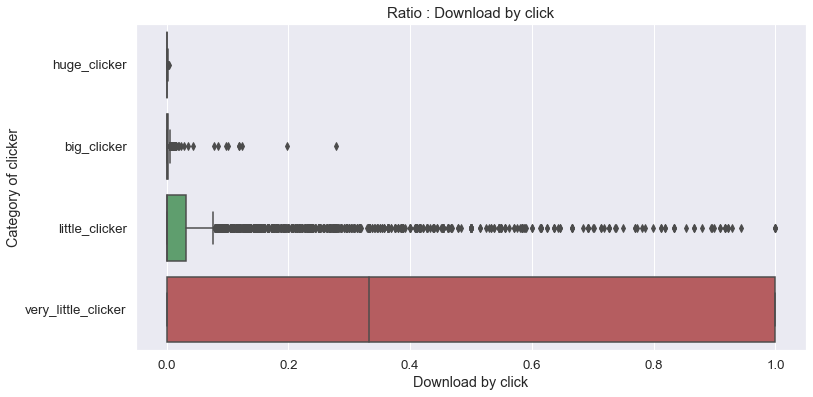

In [44]:
sns.boxplot(x='download_rate_by_ip', y='clicker_type', data=df_by_ip)
plt.title('Ratio : Download by click', fontsize=15)
plt.xlabel('Download by click')
plt.ylabel('Category of clicker')
plt.show()

The relation looks obvious : biger the number of clicks is, lower the ratio is. In other words, bots spam clicks, download the app multiples times, but way less clicks from them lead to downloads.

## Channel

In [45]:
df_by_channel = extract_agg(train, 'channel')

### Check if Channel can be used to predict conversion rate.

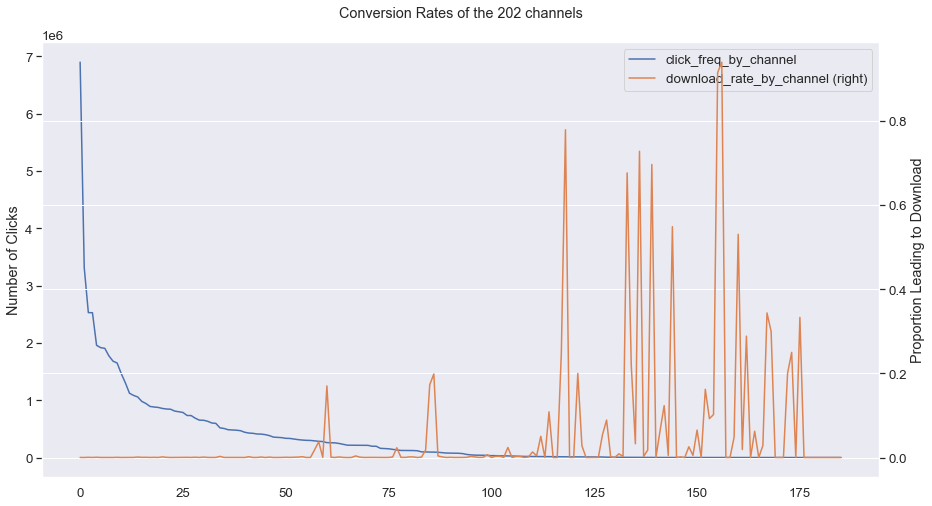

In [46]:
ax = df_by_channel[['click_freq_by_channel', 'download_rate_by_channel']].plot(secondary_y='download_rate_by_channel')
plt.title('Conversion Rates of the 202 channels', pad=25)
ax.set(ylabel='Number of Clicks')
plt.ylabel('Proportion Leading to Download');
plt.gcf().set_size_inches(15, 8)

Certain channels (certain app publishers) get a lot more click conversions than others (shown by the orange spikes). 

### Distribution

See If Ad network companies applications conduct click fraud, is the number of clicks increased with a specific channel?

Next, let's take a look at the number of clicks per channel.

If the advertisement publisher make an fraud click to gain profit, we can see data that the number of clicks for a specific channel is large.

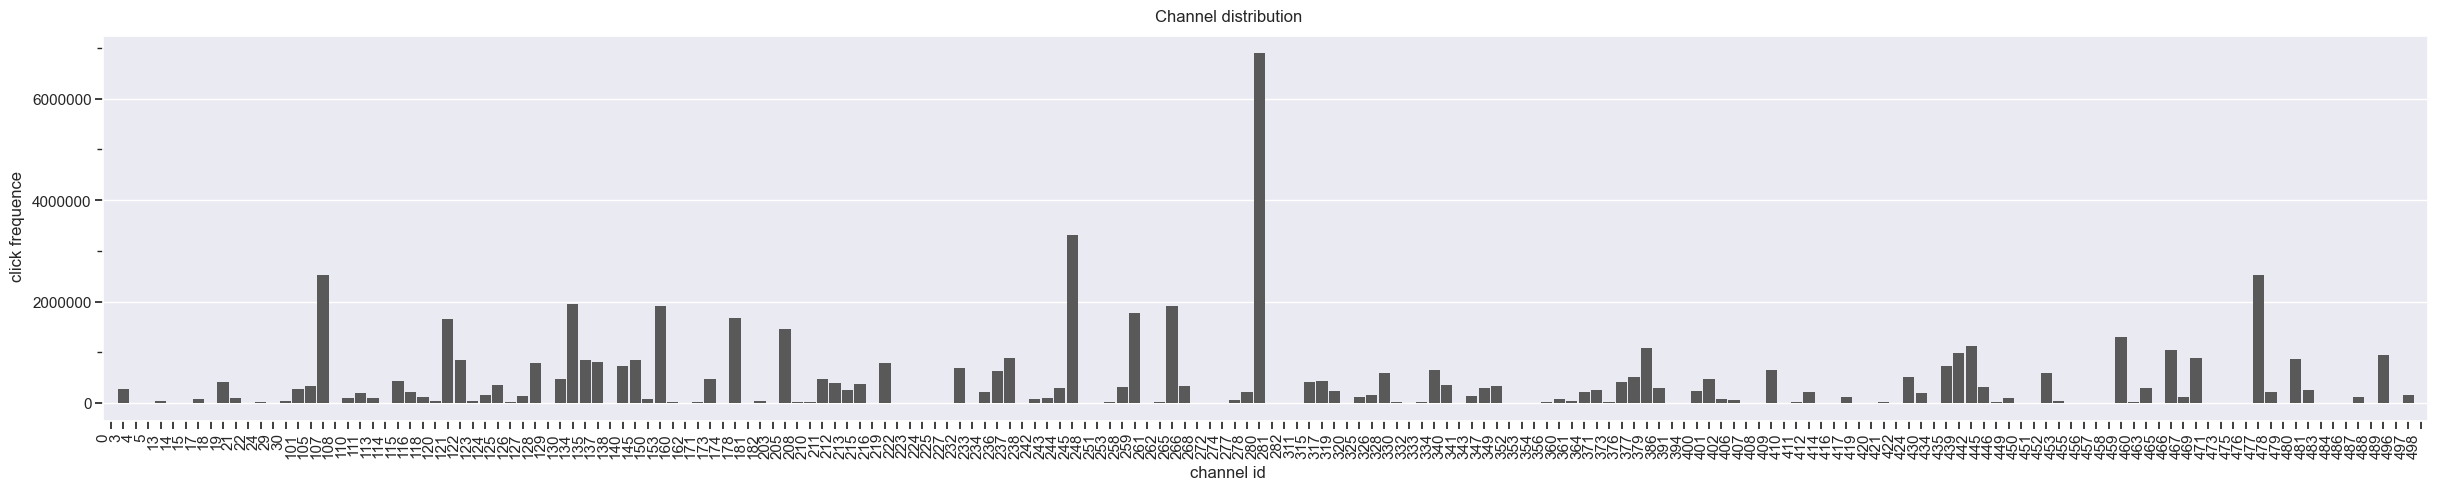

In [50]:
from plotnine import *
print(ggplot(df_by_channel) + 
          aes(x="factor(channel)", y="click_freq_by_channel") + 
          geom_col() +
          labs(x="channel id", y="click frequence", title="Channel distribution") +
          theme_seaborn(style='darkgrid') +
          theme(figure_size = (30, 5),
                panel_grid_major_x = element_blank(),
                axis_text_x = element_text(rotation=90, hjust=1)))

There are many clicks on a specific channel, but this may be just a large frequency of advertisements.

Let's see the top ten channels with many clicks.

In [51]:
df_by_channel

channel  click_freq_by_channel  download_rate_by_channel  \
0        280                6898642                   0.00022   
1        245                3313410                   0.00008   
2        107                2528941                   0.00050   
3        477                2526673                   0.00017   
4        134                1957915                   0.00061   
..       ...                    ...                       ...   
181      227                      1                   0.00000   
182       29                      1                   0.00000   
183      354                      1                   0.00000   
184      394                      1                   0.00000   
185      434                      1                   0.00000   

     download_freq_by_channel  
0                        1523  
1                         266  
2                        1272  
3                         438  
4                        1201  
..                        ...  
181                         0  
182                         0  
183                         0  
184                         0  
185                         0  

[186 rows x 4 columns]

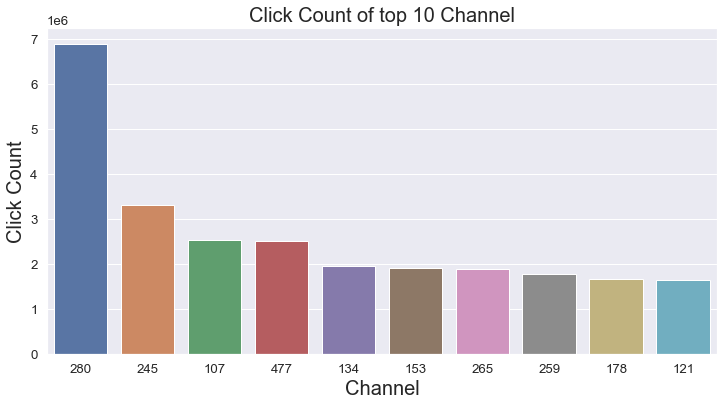

In [52]:
sns.barplot(x='channel', y='click_freq_by_channel', data=df_by_channel[:10], order=df_by_channel[:10]["channel"])
plt.xlabel("Channel", fontsize=20)
plt.ylabel("Click Count", fontsize=20)
plt.title("Click Count of top 10 Channel", fontsize=20)
plt.show()

There are many clicks in No.280 channel in particular. Other channels are nearly flat.

Let's also look at the download rate of this top ten channels with many clicks.m

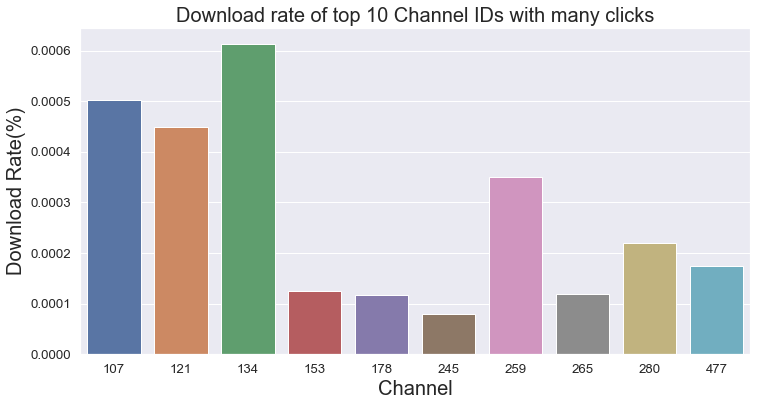

In [53]:
sns.barplot(x='channel', y='download_rate_by_channel', data=df_by_channel.sort_values(by='click_freq_by_channel', ascending=False)[:10])
plt.xlabel("Channel", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 Channel IDs with many clicks", fontsize=20)
plt.show()

## App

In [54]:
df_by_app = extract_agg(train, 'app')

### Effect of App on Click Conversions

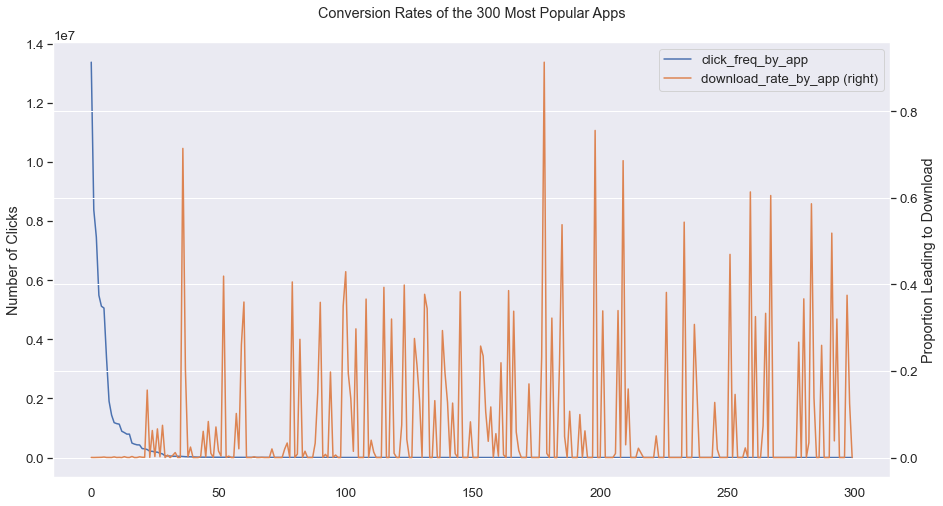

In [55]:
ax = df_by_app[0:300][['click_freq_by_app', 'download_rate_by_app']].plot(secondary_y='download_rate_by_app')
plt.title('Conversion Rates of the 300 Most Popular Apps',pad=25)
ax.set(ylabel = 'Number of Clicks')
plt.ylabel('Proportion Leading to Download');
plt.gcf().set_size_inches(15, 8)

Very similar results... We see certain apps have higher click conversion rates than other apps.

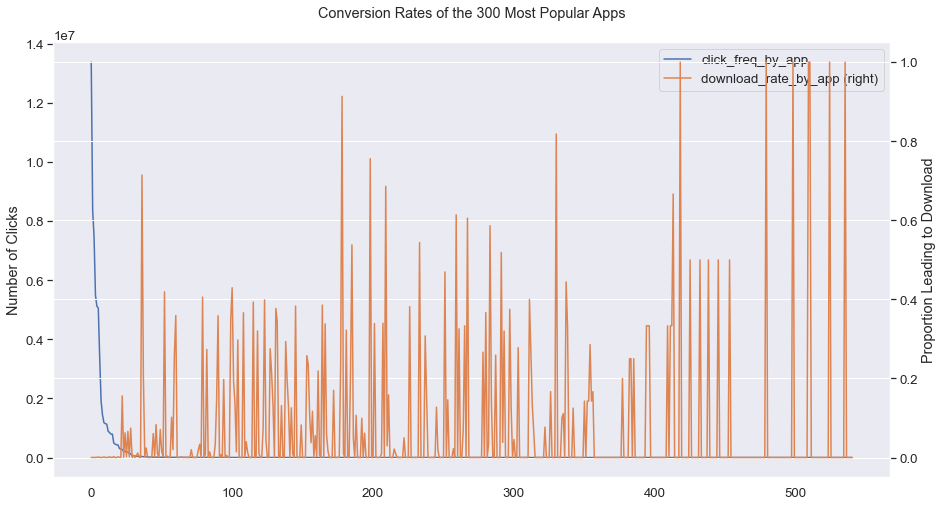

In [56]:
ax = df_by_app[['click_freq_by_app', 'download_rate_by_app']].plot(secondary_y='download_rate_by_app')
plt.title('Conversion Rates of the 300 Most Popular Apps',pad=25)
ax.set(ylabel = 'Number of Clicks')
plt.ylabel('Proportion Leading to Download');
plt.gcf().set_size_inches(15, 8)

## Device

Now let's look at the number of clicks on the same device, OS.

Click frauder may have many cheap device, and their device may be not updated. There are many possibilities to use a specific device, OS.

Let's first look at the number of clicks for each device id.

In [57]:
df_by_device = extract_agg(train, 'device')

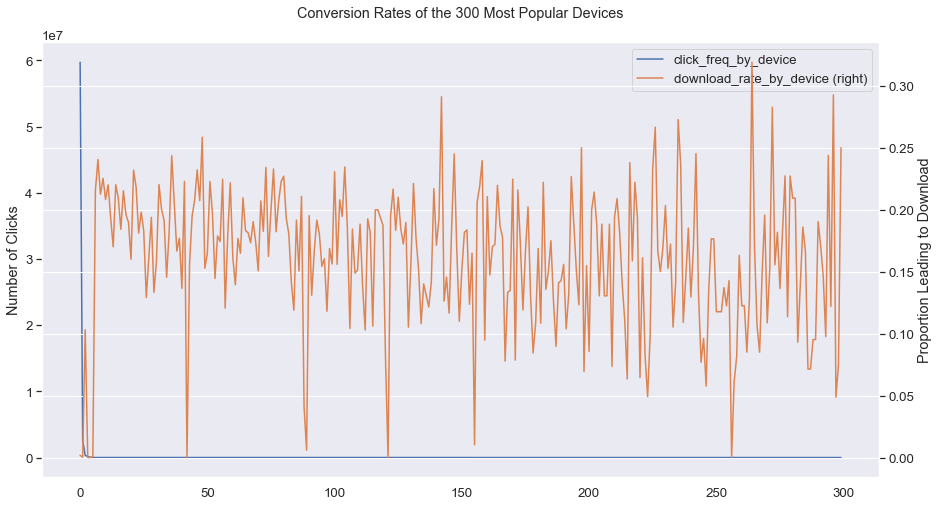

In [58]:
ax = df_by_device[0:300][['click_freq_by_device', 'download_rate_by_device']].plot(secondary_y='download_rate_by_device')
plt.title('Conversion Rates of the 300 Most Popular Devices',pad=25)
ax.set(ylabel = 'Number of Clicks')
plt.ylabel('Proportion Leading to Download');
plt.gcf().set_size_inches(15, 8)

Interstingly, we see that certain devices have higher conversion rates than others. Particularly, we see some devices have an extremely high number of clicks but a 0% download rate. These devices are most likely click-bots.

### the top 10 download rate of the device with many clicks.

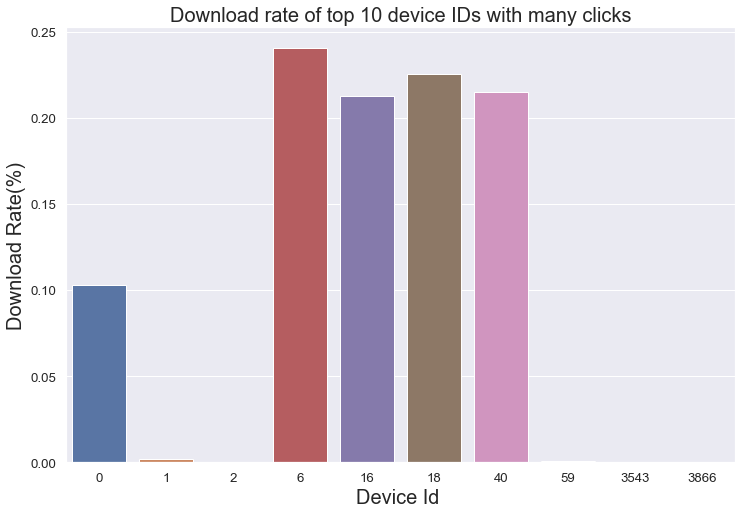

device  click_freq_by_device  download_rate_by_device  \
0       1              59716481                  0.00176   
1       2               2625486                  0.00029   
2       0                310543                  0.10315   
3    3543                170509                  0.00001   
4    3866                 29535                  0.00000   
5      59                  8885                  0.00068   
6      40                  4095                  0.21533   
7       6                  3978                  0.24060   
8      16                  3172                  0.21252   
9      18                  2192                  0.22534   

   download_freq_by_device  
0                   105243  
1                      756  
2                    32032  
3                        2  
4                        0  
5                        5  
6                      881  
7                      957  
8                      674  
9                      493

In [59]:
plt.figure(figsize=(12,8))
sns.barplot(x='device', y='download_rate_by_device', data=df_by_device[:10])
plt.xlabel("Device Id ", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 device IDs with many clicks", fontsize=20)
plt.show()

df_by_device[:10]

### number of clicks by device

In [60]:
df_by_device['click_freq_by_device'].describe(percentiles = np.arange(1,10) / 10)

count       2233.00000
mean       28188.56919
std      1264929.39203
min            1.00000
10%            1.00000
20%            1.00000
30%            2.00000
40%            2.00000
50%            4.00000
60%            6.00000
70%           10.00000
80%           20.00000
90%           61.00000
max     59716481.00000
Name: click_freq_by_device, dtype: float64

### download rate by device

In [61]:
df_by_device['download_rate_by_device'] = df_by_device['download_freq_by_device'] / df_by_device['click_freq_by_device']
df_by_device['download_rate_by_device'].describe(percentiles = np.arange(1,10) / 10)

count   2233.00000
mean       0.12460
std        0.23471
min        0.00000
10%        0.00000
20%        0.00000
30%        0.00000
40%        0.00000
50%        0.00000
60%        0.05053
70%        0.13113
80%        0.19561
90%        0.35000
max        1.00000
Name: download_rate_by_device, dtype: float64

## OS

In [62]:
df_by_os = extract_agg(train, 'os')

sns.barplot(x='os', y='click_freq_by_os', data=df_by_os.sort_values(by='click_freq_by_os', ascending=False))
plt.xlabel("Channel", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 Channel IDs with many clicks", fontsize=20)
plt.show()

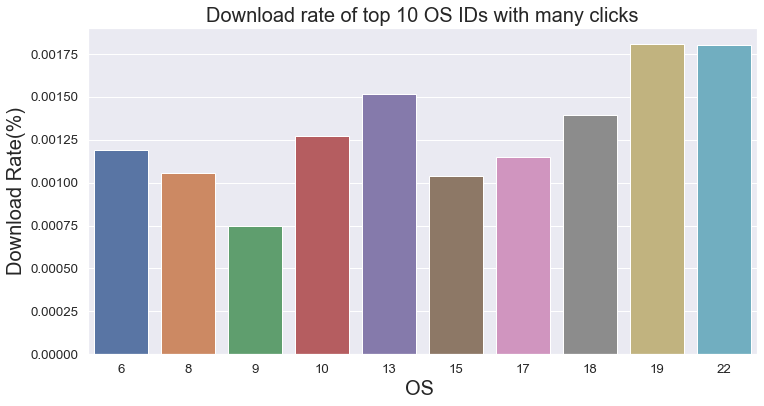

os  click_freq_by_os  download_rate_by_os  download_freq_by_os
0  19          15119852              0.00181                27368
1  13          13585973              0.00152                20639
2  17           3296380              0.00115                 3794
3  18           3079655              0.00139                 4293
4  22           2560611              0.00180                 4615
5   8           1812466              0.00105                 1909
6  10           1805507              0.00127                 2293
7   6           1561669              0.00119                 1861
8  15           1522744              0.00104                 1581
9   9           1469733              0.00075                 1096

In [63]:
sns.barplot(x='os', y='download_rate_by_os', data=df_by_os[:10])
plt.xlabel("OS ", fontsize=20)
plt.ylabel("Download Rate(%)", fontsize=20)
plt.title("Download rate of top 10 OS IDs with many clicks", fontsize=20)
plt.show()

df_by_os[:10]

Here is only the 8 OS Only the number of downloads is 0, no noticeable difference is not seen.

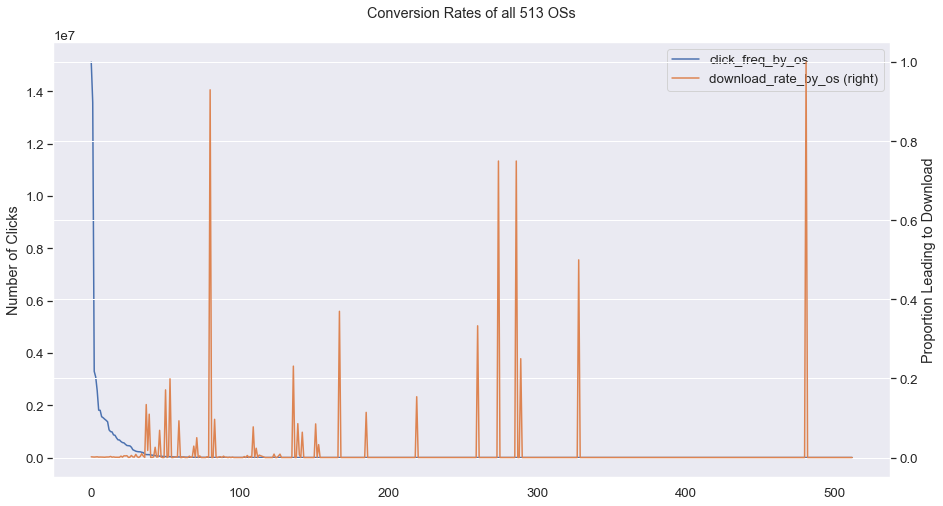

In [64]:
ax = df_by_os[['click_freq_by_os', 'download_rate_by_os']].plot(secondary_y='download_rate_by_os')
plt.title('Conversion Rates of all 513 OSs',pad=25)
ax.set(ylabel = 'Number of Clicks')
plt.ylabel('Proportion Leading to Download');
plt.gcf().set_size_inches(15, 8)

## app

In [65]:
df_by_app = extract_agg(train, 'app')

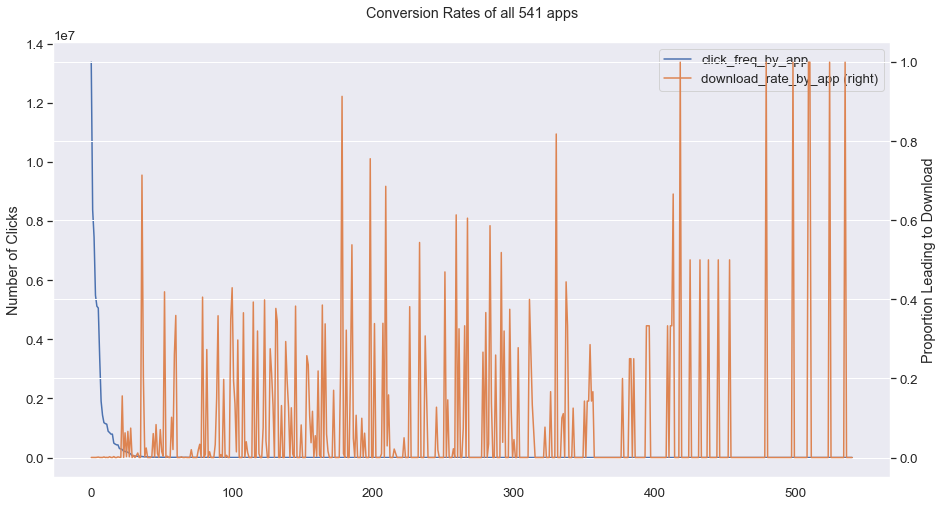

In [66]:
ax = df_by_app[['click_freq_by_app', 'download_rate_by_app']].plot(secondary_y='download_rate_by_app')
plt.title('Conversion Rates of all 541 apps',pad=25)
ax.set(ylabel = 'Number of Clicks')
plt.ylabel('Proportion Leading to Download');
plt.gcf().set_size_inches(15, 8)

## click_time

In [67]:
df_by_hour = extract_agg(train, 'hour')

### total number of clicks over the days

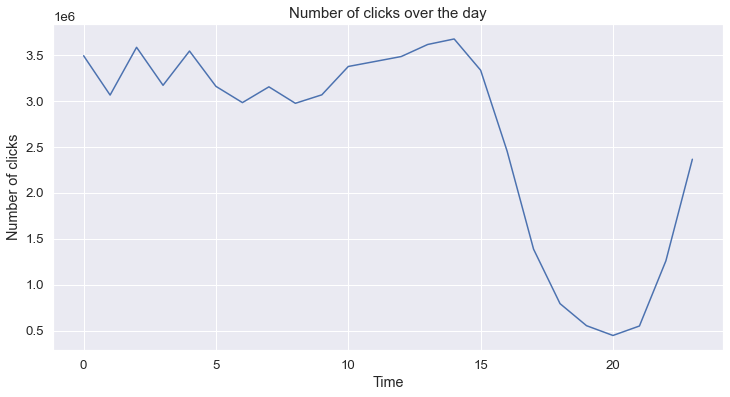

In [68]:
df_by_hour.sort_values('hour', ignore_index=True).set_index("hour")['click_freq_by_hour'].plot()
plt.title('Number of clicks over the day', fontsize = 15)
plt.xlabel('Time')
plt.ylabel('Number of clicks');

### download rate over the days

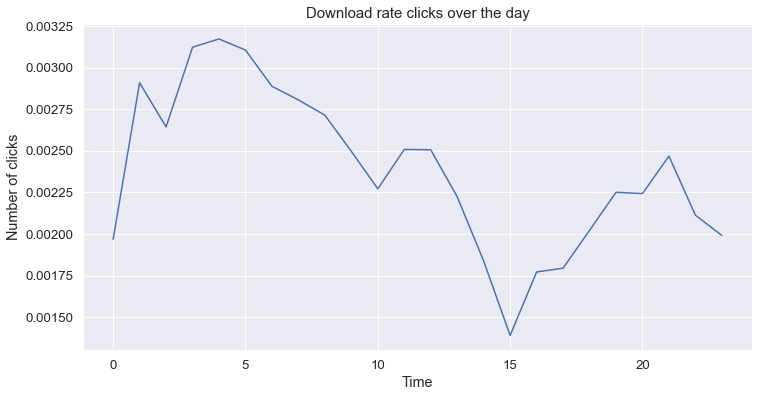

In [69]:
df_by_hour.sort_values('hour', ignore_index=True).set_index("hour")['download_rate_by_hour'].plot()
plt.title('Download rate clicks over the day', fontsize = 15)
plt.xlabel('Time')
plt.ylabel('Number of clicks');

### total number of clicks per hour

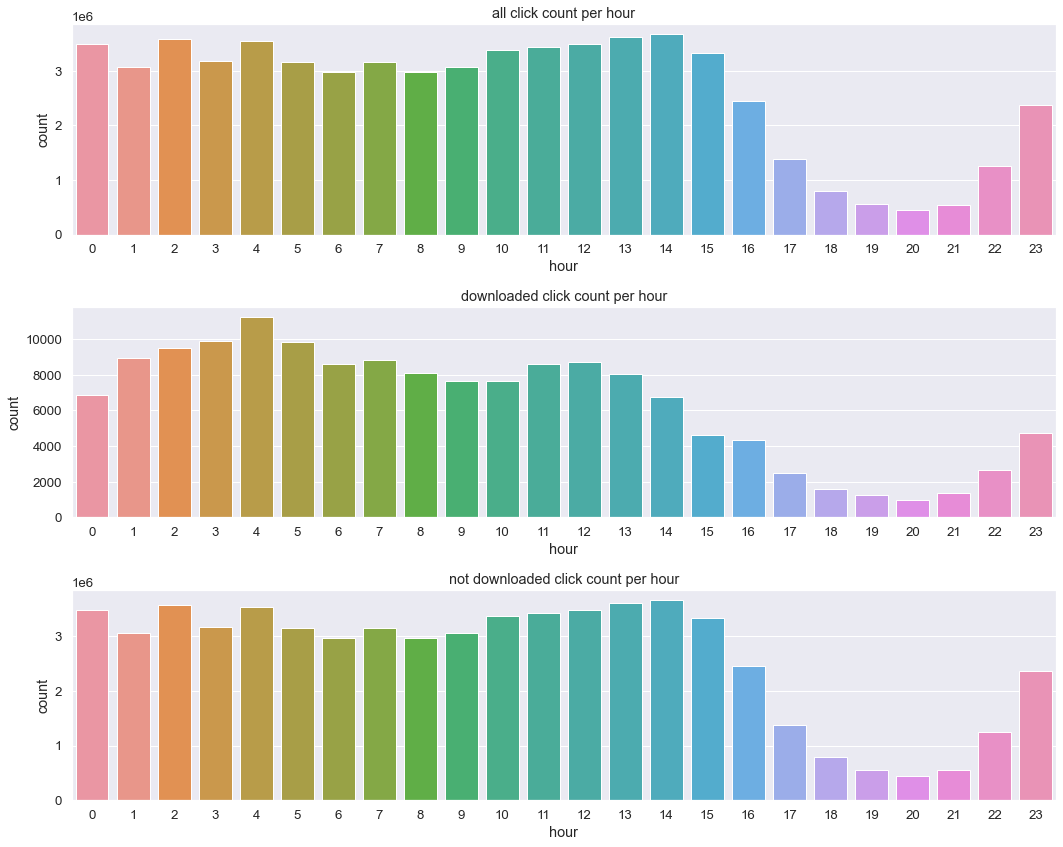

In [70]:
dll_df = train[train['is_attributed'] == 1]
not_dll_df = train[train['is_attributed'] == 0]

fig ,ax = plt.subplots(3,1, figsize= (15, 12))

sns.countplot(x='hour', data=train, ax=ax[0]);
sns.countplot(x='hour', data=dll_df, order=[i for i in range(24)] , ax=ax[1])
sns.countplot(x='hour', data=not_dll_df,  ax=ax[2])
ax[0].set_title('all click count per hour')
ax[1].set_title('downloaded click count per hour')
ax[2].set_title('not downloaded click count per hour')
plt.tight_layout()
plt.show()

We are plotting the total number of clicks per hour, the number of clicks downloaded and the number of clicks not downloaded respectively. The number of clicks are commonly falling from 18 to 22 o'clock, but there is no big difference in the three graphs.

### download rate for the number of clicks per hour.

AttributeError: 'numpy.ndarray' object has no attribute 'set_title'

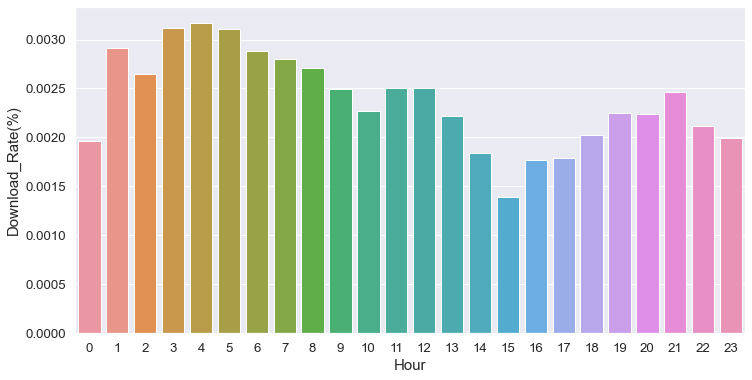

In [71]:
sns.barplot(x='hour', y='download_rate_by_hour', data=df_by_hour)
plt.ylabel('Download_Rate(%)', fontsize=15)
plt.xlabel('Hour', fontsize=15)
ax.set_title('Download Rate per Hour', fontsize = 20);

- In the evening, the number of downloads is declining, and is declining too. This is not a very good graph.
- Because the download rate is too small, if one download column is added, the result will change dramatically.
- If click frauder click on the computer automatically, clicks may have occurred every ten minutes.

## Arributed time

**We probably won't be able to use attributed_time as a predictor; if we know the time at which the user downloaded it, we already know is_attributed==1**

**In essence, we have found that for all variables (excluding time and IPs) there are spikes in the data that indicate higher chances of a click leading to a download. Ideally, our model will be able to identify and use the information from these spikes.**

In [ ]:
train_positive = train[train['is_attributed'] == 1]
train_positive['gap'] = pd.to_datetime(train_positive['attributed_time']).sub(pd.to_datetime(train_positive['click_time']))
train_positive['gap'].describe(percentiles = np.arange(10) / 10)

In [ ]:
import matplotlib.ticker as ticker
@ticker.FuncFormatter
def major_formatter(x, pos):
    return str(datetime.timedelta(seconds=x))

temp = train_positive.copy()
temp['gap'] = temp['gap'].dt.seconds
ax = pt.half_violinplot(x='gap', data=temp, bw=.2, cut = 0, scale = "area", width = .6, inner = None)
ax = sns.stripplot(x='gap', data=temp, edgecolor = "white",size = 3, jitter = 1, zorder = 0)
ax = sns.boxplot(x='gap', data=temp, color="black", width = .15, zorder = 10,boxprops = {'facecolor':'none', "zorder":10},
        showcaps=True, showfliers=True,\
        saturation=1)
xticks = ax.get_xticks()
start, end = min(temp['gap']), max(temp['gap'])
plt.xticks(rotation=50)
ax.xaxis.set_ticks(np.linspace(start=start, stop=end, num=10))
# convert all xtick labels to selected format from ms timestamp
ax.xaxis.set_major_formatter(major_formatter)

# Checking for time patterns

Round the click time down to an hour of the day to see if there are any hourly patterns.

For this part cannot use the first n rows from train data, as it's organized by time.  To get a genral idea for the pattern, will use train data from the randomly sampled 100000 train set provided by organizers.

In [ ]:
train_smp = pd.read_csv('../input/train_sample.csv')

In [ ]:
train_smp.head(7)

In [ ]:
#convert click_time and attributed_time to time series
train_smp['click_time'] = pd.to_datetime(train_smp['click_time'])
train_smp['attributed_time'] = pd.to_datetime(train_smp['attributed_time'])

In [ ]:
#round the time to nearest hour
train_smp['click_rnd']=train_smp['click_time'].dt.round('H')  

#check for hourly patterns
train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

train_smp[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

There is no clear hourly time pattern in ratios, however there is a definete pattern in frequency of clicks based on time of day.

Lets extract the hour of day from each day as a separate feature, and see combined trend (merge the 4 days together by hour).

In [275]:
#extract hour as a feature
train_smp['click_hour']=train_smp['click_time'].dt.hour

In [276]:
train_smp.head(7)

ip  app  device  os  channel          click_time attributed_time  \
0   87540   12       1  13      497 2017-11-07 09:30:38             NaT   
1  105560   25       1  17      259 2017-11-07 13:40:27             NaT   
2  101424   12       1  19      212 2017-11-07 18:05:24             NaT   
3   94584   13       1  13      477 2017-11-07 04:58:08             NaT   
4   68413   12       1   1      178 2017-11-09 09:00:09             NaT   
5   93663    3       1  17      115 2017-11-09 01:22:13             NaT   
6   17059    1       1  17      135 2017-11-09 01:17:58             NaT   

   is_attributed           click_rnd  click_hour  
0              0 2017-11-07 10:00:00           9  
1              0 2017-11-07 14:00:00          13  
2              0 2017-11-07 18:00:00          18  
3              0 2017-11-07 05:00:00           4  
4              0 2017-11-09 09:00:00           9  
5              0 2017-11-09 01:00:00           1  
6              0 2017-11-09 01:00:00           1

Let's check number of clicks by hour:

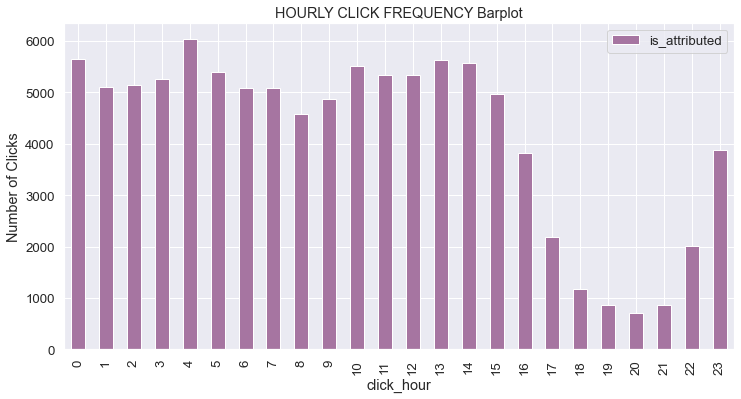

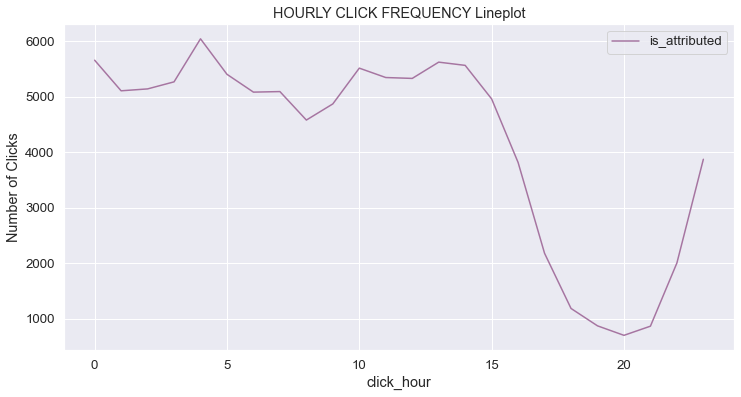

In [277]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Barplot');
plt.ylabel('Number of Clicks');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='#a675a1')
plt.title('HOURLY CLICK FREQUENCY Lineplot');
plt.ylabel('Number of Clicks');

And number of conversions by hours:

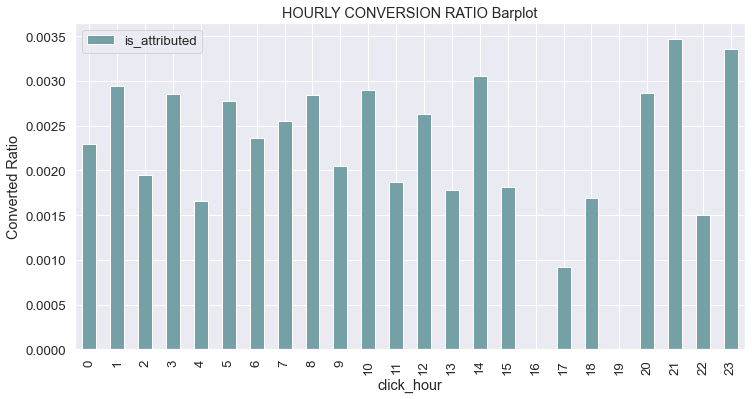

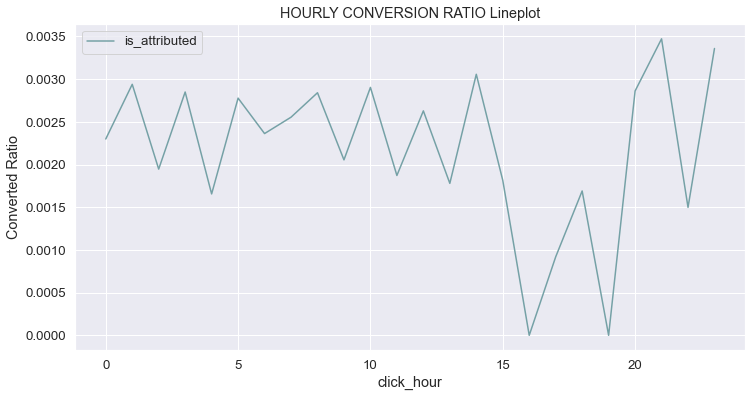

In [278]:
train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot');
plt.ylabel('Converted Ratio');

train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot');
plt.ylabel('Converted Ratio');

let's overlay the two graphs to see if patterns correlate in any way

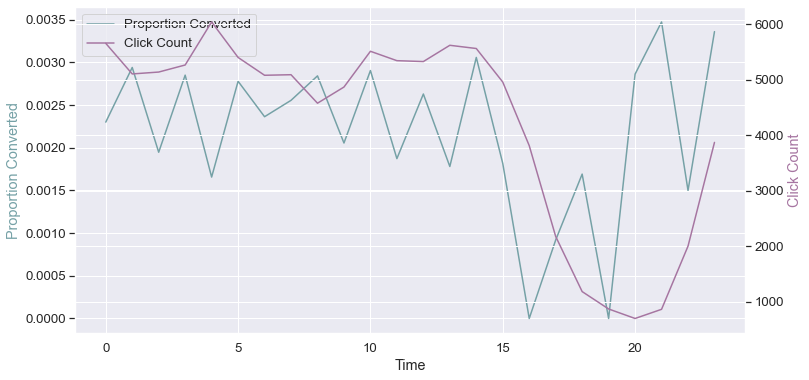

In [279]:
#adapted from https://stackoverflow.com/questions/9103166/multiple-axis-in-matplotlib-with-different-scales
#smonek's answer


group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_smp[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
color1 = '#75a1a6'
color2 = '#a675a1'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())

plt.savefig("pyplot_multiple_y-axis.png", bbox_inches='tight')

The proportions may be more reliable if estimated on full data.  With the random sample it's  hard too tell because the variability is too high, especially for the hours with low click counts.   i.e. the fewer clicks/conversions, the wider margin of the estimated conversion ratio.  (see below)

/Users/jace/opt/anaconda3/envs/PYFORAML/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


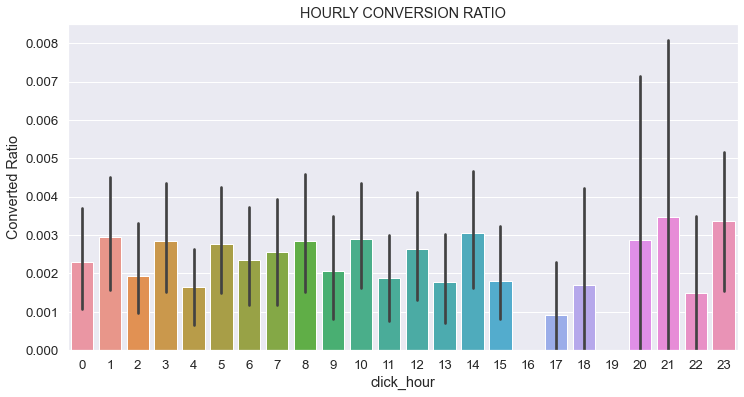

In [280]:
sns.barplot('click_hour', 'is_attributed', data=train_smp)
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

## Look into attributed_time
It could be useful to learn more about conversions that did take place.
Let's see how much time passed from clicking on the ad to downloading it.

In [281]:
train_smp['timePass']= train_smp['attributed_time']-train_smp['click_time']
#check:
train_smp[train_smp['is_attributed']==1][:15]

ip  app  device  os  channel          click_time  \
284   224120   19       0  29      213 2017-11-08 02:22:13   
481   272894   10       1   7      113 2017-11-08 06:10:05   
1208   79001   19       0   0      213 2017-11-07 09:54:22   
1341  131029   19       0   0      343 2017-11-09 10:58:46   
1412   40352   19       0   0      213 2017-11-07 22:19:03   
1666   48733   35       1  18      274 2017-11-07 12:25:50   
1771  330861   35       1  22       21 2017-11-08 18:54:44   
1917  309576    5       1  32      113 2017-11-09 08:47:51   
3914  220571   71       1  25        3 2017-11-08 04:35:21   
3992  240051   35       1  19       21 2017-11-08 08:07:13   
4300  110652   19      16   0      213 2017-11-09 08:15:34   
4424  252612    5       1  31      113 2017-11-07 20:21:11   
4564   48072   19      21  24      213 2017-11-07 05:17:29   
4603   12506   62       1  19       21 2017-11-08 05:56:57   
4607  184467   35       1  30      274 2017-11-07 22:29:06   

         attributed_time  is_attributed           click_rnd  click_hour  \
284  2017-11-08 02:22:38              1 2017-11-08 02:00:00           2   
481  2017-11-08 06:10:37              1 2017-11-08 06:00:00           6   
1208 2017-11-07 11:59:05              1 2017-11-07 10:00:00           9   
1341 2017-11-09 11:52:01              1 2017-11-09 11:00:00          10   
1412 2017-11-08 01:55:02              1 2017-11-07 22:00:00          22   
1666 2017-11-07 13:10:30              1 2017-11-07 12:00:00          12   
1771 2017-11-08 22:39:52              1 2017-11-08 19:00:00          18   
1917 2017-11-09 08:47:55              1 2017-11-09 09:00:00           8   
3914 2017-11-08 04:37:46              1 2017-11-08 05:00:00           4   
3992 2017-11-08 09:46:42              1 2017-11-08 08:00:00           8   
4300 2017-11-09 09:30:19              1 2017-11-09 08:00:00           8   
4424 2017-11-07 20:21:42              1 2017-11-07 20:00:00          20   
4564 2017-11-07 06:49:01              1 2017-11-07 05:00:00           5   
4603 2017-11-08 08:56:58              1 2017-11-08 06:00:00           5   
4607 2017-11-08 00:16:14              1 2017-11-07 22:00:00          22   

            timePass  
284  0 days 00:00:25  
481  0 days 00:00:32  
1208 0 days 02:04:43  
1341 0 days 00:53:15  
1412 0 days 03:35:59  
1666 0 days 00:44:40  
1771 0 days 03:45:08  
1917 0 days 00:00:04  
3914 0 days 00:02:25  
3992 0 days 01:39:29  
4300 0 days 01:14:45  
4424 0 days 00:00:31  
4564 0 days 01:31:32  
4603 0 days 03:00:01  
4607 0 days 01:47:08

In [282]:
train_smp['timePass'].describe()

count                          227
mean     0 days 01:14:59.572687224
std      0 days 02:25:05.392661298
min                0 days 00:00:02
25%         0 days 00:00:52.500000
50%                0 days 00:03:18
75%         0 days 01:21:27.500000
max                0 days 12:52:21
Name: timePass, dtype: object

It takes as long as (almost) 20 hours to go from click to purchase and as little as 4 seconds.  

The 4 seconds seems to low to make a decision.  This person would have either seen the ad before, or already been aware of the product some other way.

Does that mean the ad was clicked on multiple times, but only one click was counted as conversion?   Or did the person click on the ad specifically with the intent to download?  (eg, if channel is something like google search, the ad could be clicked during search results view and app downloaded immediately because that's what the person intended to do right away)

Raises questions to explore:
   - How accurately are conversions tracked? How are clicks and downloads linked?  What happens if download after multiple clicks?  Is there a way to identify likely same users (same IP, Device, etc...)

## Check actual train data (the first 10,000,000)
double check the same feature on the first 10 million rows of train data:

In [290]:
train[['ip', 'hour', 'click_freq_by_ip_hour']].groupby('

ip  hour  click_freq_by_ip_hour
0          48240     0                   1875
1          81121     0                    687
2           6424     0                    167
3          11109     0                    276
4          85980     0                     76
...          ...   ...                    ...
62945070  206025    23                      3
62945071  137983    23                     19
62945072  118315    23                   1495
62945073   95663    23                    251
62945074  174766    23                     69

[62945075 rows x 3 columns]

In [283]:
#check first 10,000,000 of actual train data
train['timePass']= train['attributed_time']-train['click_time']
train['timePass'].describe()

count                       153321
mean     0 days 01:31:23.116572419
std      0 days 03:03:02.393626798
min                0 days 00:00:00
25%                0 days 00:00:56
50%                0 days 00:05:19
75%                0 days 01:26:53
max                0 days 23:55:10
Name: timePass, dtype: object

Here minimum time from click to download is virtually instanteneous.  How is this possible?  It is clearly not a result of a human decision made from clicking on an ad seen for the first time.

# click frequency

In [109]:
train_df = train.copy()

In [110]:
def datetime_to_deltas(series, delta=np.timedelta64(1, 's')):
    t0 = series.min()
    return ((series-t0)/delta).astype(np.int32)

train_df['sec'] = datetime_to_deltas(train_df.click_time)
print('Added seconds')

train_df.drop('click_time', axis=1, inplace=True)
print('Dropped click_time')

Added seconds
Dropped click_time


In [111]:
from matplotlib.colors import LogNorm

# e.g. train_df.loc[train_df.ip==234]
def generate_plot(df):
    w = 600
    n = df.sec.max()+1
    l = int(np.ceil(n/float(w))*w)
    c = np.zeros(l, dtype=np.float32)
    np.add.at(c, df.sec.values, 1)
    print(f'total clicks {c.sum():.0f} \t max clicks {c.max():.0f} \t mean click rate {c.mean():.02f} ')
    return c.reshape((-1,w))

def show(pix, title):
    pix += 1 # matplotlib restriction
    ysize = 5 if pix.shape[0] < 400 else 8
    fig, ax0 = plt.subplots(figsize=(18, ysize))
    ax0.invert_yaxis()
    ax0.set_yticks(np.arange(0, pix.shape[0], 144))
    ax0.set_yticks(np.arange(0, pix.shape[0], 6))
    ax0.set_xticks(np.arange(0, pix.shape[1], 60))
    ax0.set_xticks(np.arange(0, pix.shape[1], 10))
    c = ax0.pcolormesh(pix, norm=LogNorm(vmin=1, vmax=pix.max()), cmap='afmhot')
    ax0.set_title(title)
    return fig.colorbar(c, ax=ax0)

def gen_show(df, col, value):
    idx = df[col]==value
    if idx.sum()<1:
        print('Not found!')
    else:
        pix = generate_plot(df.loc[idx])
        show(pix, f'{col} {value}')

## Apps

App 1, strong periodic behaviour every minute, and a comb-like pattern on the right (some hourly regularity?)


total clicks 2044757 	 max clicks 153 	 mean click rate 23.67 


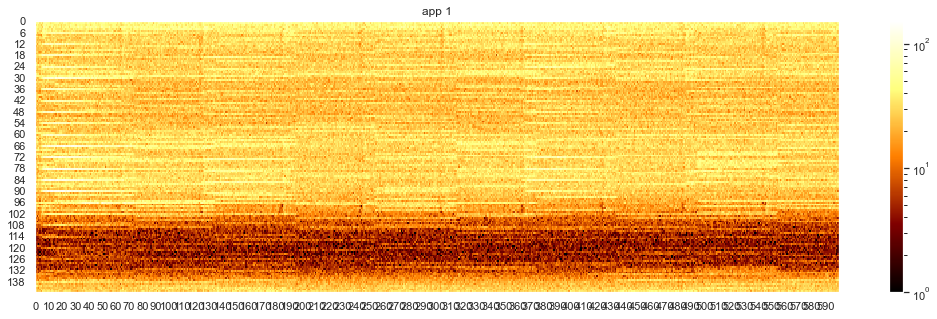

In [113]:
gen_show(train_df, 'app', 1)

App 7, heavy but short spikes.


total clicks 357968 	 max clicks 96 	 mean click rate 4.14 


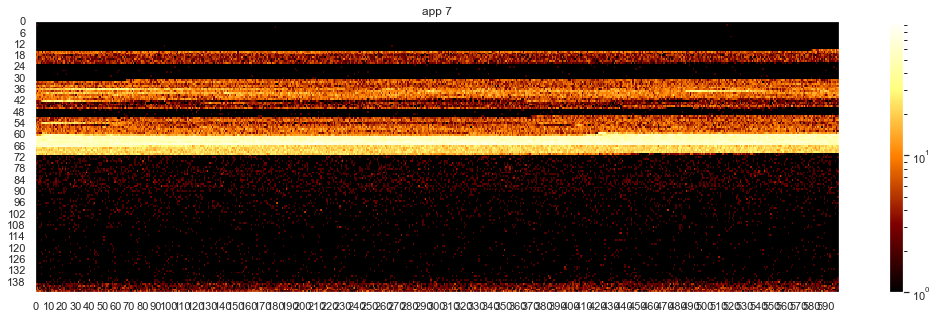

In [114]:
gen_show(train_df, 'app', 7)

App 20, very striking mechanistic behaviour, busy one minute, quiet the next!


total clicks 712219 	 max clicks 42 	 mean click rate 8.24 


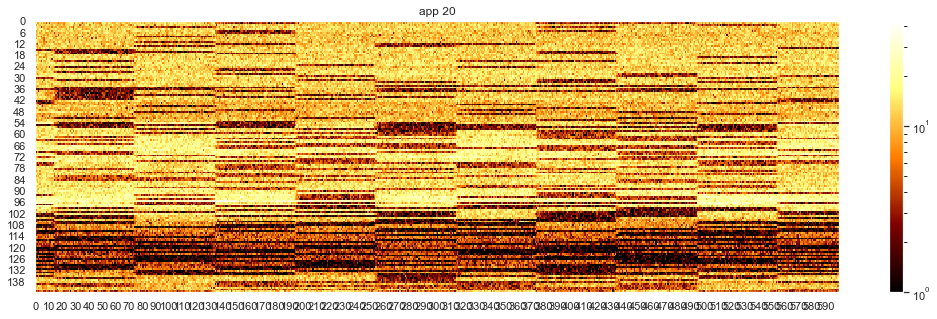

In [115]:
gen_show(train_df, 'app', 20)

App 151, this is the most clicked app in the training set that has no *is_attributed==1* records at all (a target rate of 0). Zooming in on the plot it's clearly a highly regular mechanistic pattern.


total clicks 63633 	 max clicks 8 	 mean click rate 0.74 


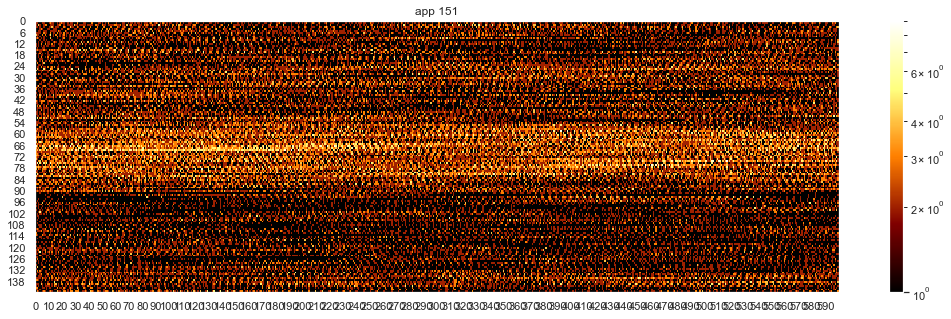

In [117]:
gen_show(train_df, 'app', 151)

App 56 is the second most clicked app with no positive targets (3rd is 183, 4th is 93), these ar similar to app 151 above but with a very heavy spike in day 2.


total clicks 2793 	 max clicks 4 	 mean click rate 0.03 


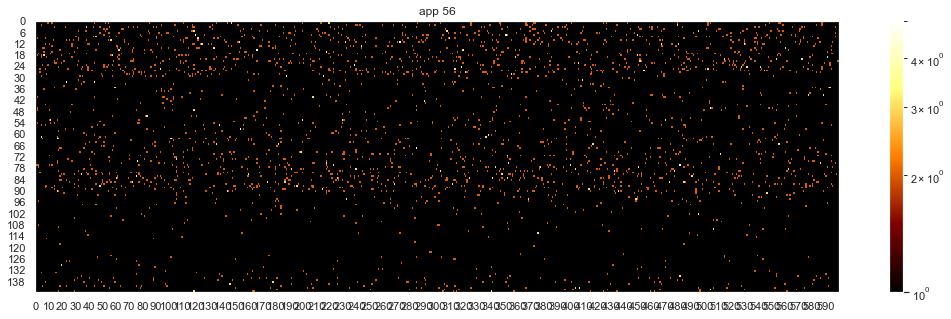

In [118]:
gen_show(train_df, 'app', 56)

## Channels

Channel 236 and 237, more periodic behaviour, phase shifting over time, in different ways. (This is a real whoa! moment... anyone have any ideas on the cause of this?)


total clicks 268895 	 max clicks 44 	 mean click rate 3.11 


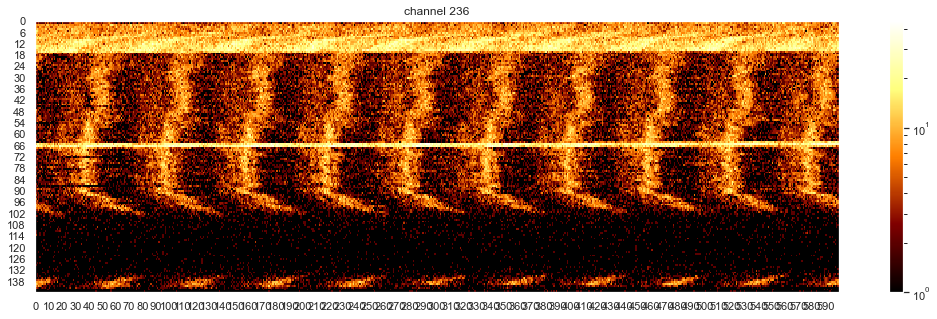

In [119]:
gen_show(train_df, 'channel', 236)

Channel 105 - more minutely switching, the exact same point in every minute, no phase drift...


total clicks 493582 	 max clicks 38 	 mean click rate 5.71 


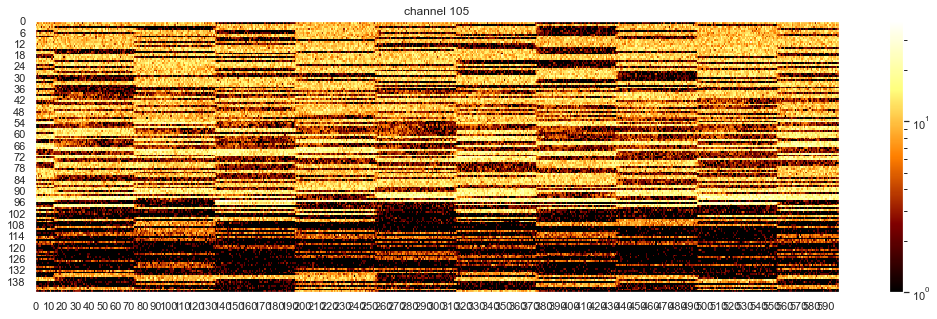

In [120]:
gen_show(train_df, 'channel', 105)

Channel 244 - some fine horizontal banding particularly visible in darker night-time periods
.

total clicks 398167 	 max clicks 21 	 mean click rate 4.61 


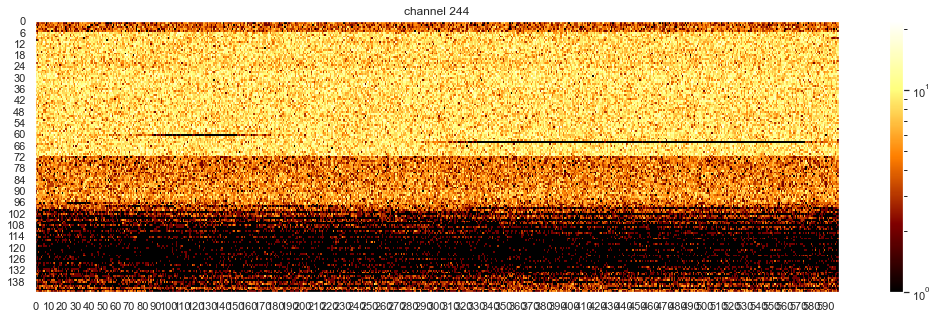

In [121]:
gen_show(train_df, 'channel', 244)

Channel 272 is low volume, but with no *is_attributed==1*, the regularity of the presumably bot-generated clicks is easier to see, with 5-6 second gaps. (Unfortunately the test set only has 79 records for channel 272... but are there other channels in the test set with click patterns with easy-to-detect regularity like this? ;)

total clicks 462 	 max clicks 2 	 mean click rate 0.01 


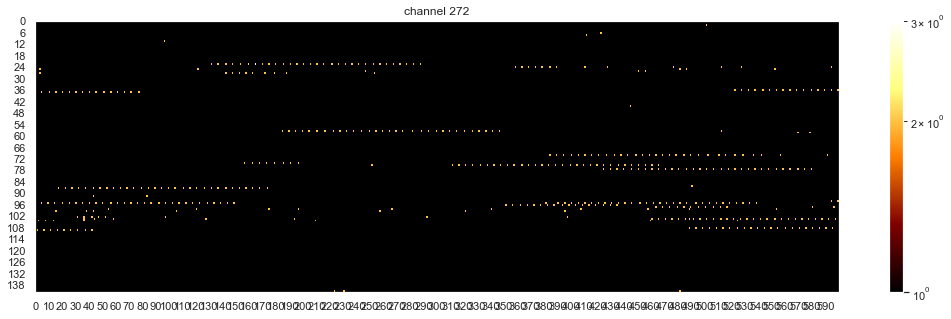

In [123]:
gen_show(train_df, 'channel', 272)

## Devices

Device 2 (2nd most common) some faint traces of patterns.


total clicks 2557735 	 max clicks 152 	 mean click rate 29.60 


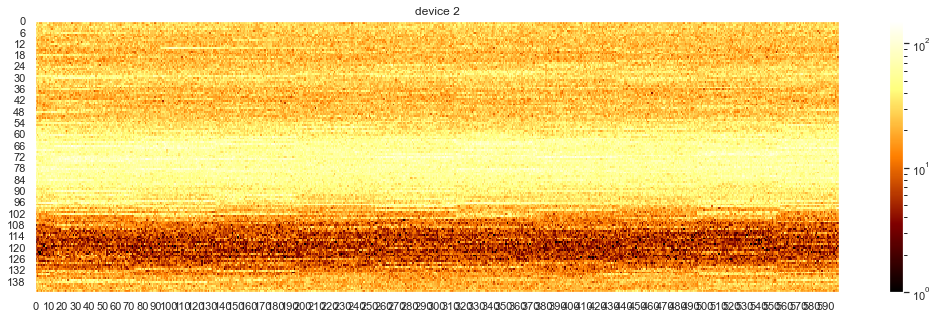

In [125]:
gen_show(train_df, 'device', 2)

Device 154, normal looking sporadic clicks, but with one streak on day 1.


total clicks 1394 	 max clicks 6 	 mean click rate 0.02 


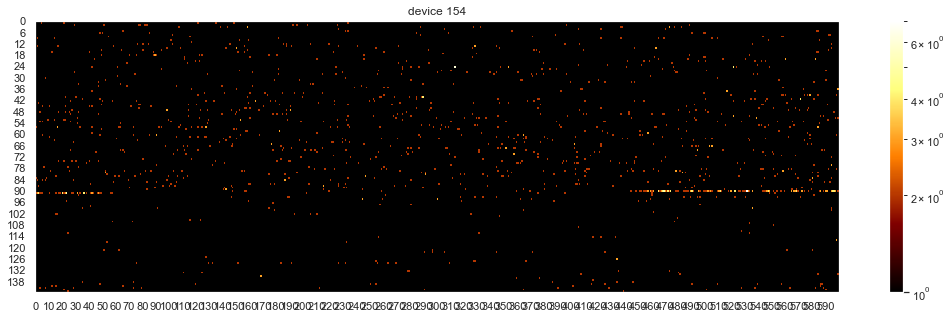

In [127]:
gen_show(train_df, 'device', 154)

## IPs

IP 5314 and 5348 - the most active IPs in train - featuring an hour or so of abnormally low activity on day 2.


total clicks 438340 	 max clicks 34 	 mean click rate 5.07 


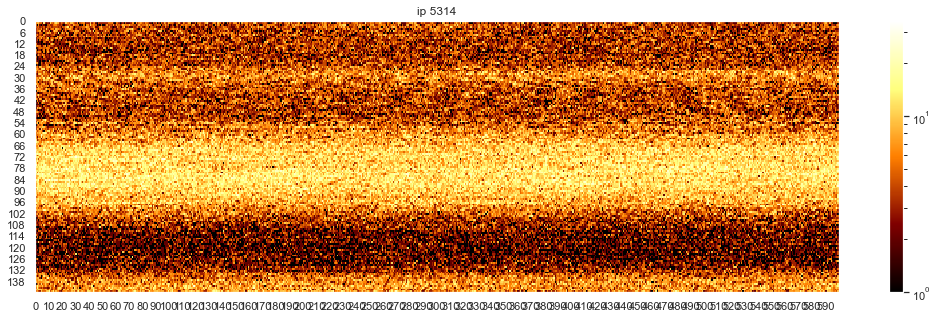

In [128]:
gen_show(train_df, 'ip', 5314)

IP 86767 - the same hour? This takes over from the other two IPs? (This may well have nothing to do with click fraud and instead be a network architecture effect.)


total clicks 90474 	 max clicks 17 	 mean click rate 1.05 


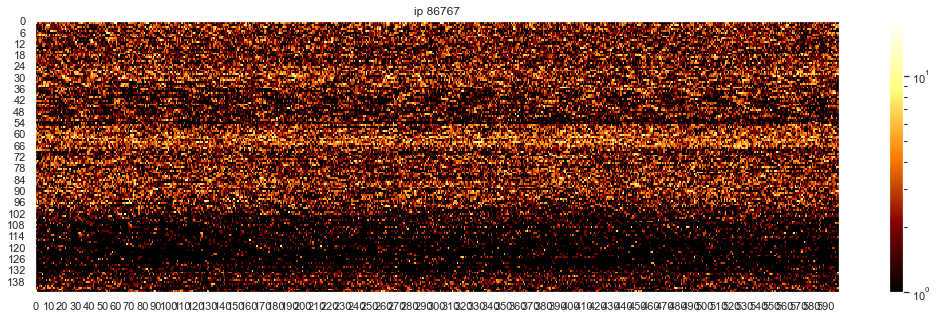

In [130]:
gen_show(train_df, 'ip', 86767)